# Machine Learning

This part will train additional networks to predict other atoms and learn more specifically how to predict different amino acid residues.


We begin with some initial classes and functions to load data

In [38]:
import random
import numpy as np
import torch
import sys
import pandas as pd

class Dataset(torch.utils.data.Dataset):
# optional parameters allow target data to be shifted and scaled
    def __init__(self, target, data):
        self.label = target.astype(np.float32)
# assumes that data is prepared in correct shape beforehand
        self.input = data
    def __len__(self):
        return self.label.shape[0]
    def __getitem__(self, index):
        return self.input[index].astype(np.float32), self.label[index]
    
def randomsplitdata(target_input_fn,training_fraction,maxrows=-1,select="CACNO",aa='all'):
    f=open(target_input_fn)
    lsplit=f.readline().split()
    f.close()

    if (maxrows>0):
        df=pd.read_csv(target_input_fn,sep=' ',header=None,nrows=maxrows)
    else:
        df=pd.read_csv(target_input_fn,sep=' ',header=None)
        
    if (aa == 'all'):
        dfaa=df
    else:
        aalist=aa.split(':')
        dfaa=df.loc[df[0].isin(aalist)]
       
    if (select == "CACNO"): 
        dft=dfaa[[*range(1,13)]]                                                 #ca, c, n, o
    elif (select == "CANCO"):
        dft=dfaa[[*range(1,4)]+[*range(7,10)]+[*range(4,7)]+[*range(10,13)]]     #ca, n, c, o
    elif (select == "CAN"):
        dft=dfaa[[*range(1,4)]+[*range(7,10)]]                                   #ca, n
    elif (select == "CAC"):
        dft=dfaa[[*range(1,7)]]                                                  #ca, c
    elif (select == "CACN"):
        dft=dfaa[[*range(1,10)]]                                                 #ca, c, n
    elif (select == "CA"):
        dft=dfaa[[*range(1,4)]]
    else:
        print('unknown selection')
        sys.exit(1)
      
    targetdata=dft.to_numpy()
    
    #print(targetdata.shape)

    dfi=dfaa[[*range(len(lsplit)-30,len(lsplit))]]
    inputdata=np.reshape(dfi.to_numpy(),(len(dfi),1,-1))
      
    xlist=[*range(len(lsplit)-30,len(lsplit),3)]
    ylist=[*range(len(lsplit)-30+1,len(lsplit),3)]
    zlist=[*range(len(lsplit)-30+2,len(lsplit),3)]
    
    dfixyz=dfi[xlist+ylist+zlist]
    inpxyzdata=np.reshape(dfixyz.to_numpy(),(len(dfi),3,-1)) 
    
    flag=np.zeros(len(targetdata),dtype=int)
    while np.average(flag)<training_fraction:
        flag[random.randint(0,len(targetdata)-1)]=1
    
    target_training=targetdata[np.nonzero(flag)].copy()
    target_validation=targetdata[np.nonzero(1-flag)].copy()
    input_training=inputdata[np.nonzero(flag)].copy()
    input_validation=inputdata[np.nonzero(1-flag)].copy()
    inputxyz_training=inpxyzdata[np.nonzero(flag)].copy()
    inputxyz_validation=inpxyzdata[np.nonzero(1-flag)].copy()
        
    return target_training,input_training,inputxyz_training, \
           target_validation,input_validation,inputxyz_validation

def get_loaders(target_input_fn,training_fraction,batch_size=128,maxrows=-1,aa='all',select="CACNO"):
    [ttarget,tinput,tinpxyz,vtarget,vinput,vinpxyz]=\
        randomsplitdata(target_input_fn,training_fraction,maxrows=maxrows,aa=aa,select=select) 
    
    train_set=Dataset(ttarget,tinput)
    validation_set=Dataset(vtarget,vinput)
    trainxyz_set=Dataset(ttarget,tinpxyz)
    valixyz_set=Dataset(vtarget,vinpxyz)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=1)
    
    trainxyz_loader = torch.utils.data.DataLoader(trainxyz_set, batch_size=batch_size, shuffle=True)
    valixyz_loader = torch.utils.data.DataLoader(valixyz_set, batch_size=1)
    
    return train_loader,validation_loader,trainxyz_loader,valixyz_loader        

We set up training functions again.

In [39]:
import numpy as np

def train(m,loss_fn,opt,loader,xscale=1.0,klfactor=0.0,klindex=0):
    klloss=nn.KLDivLoss(reduction='batchmean')
    
    loss_sum = 0.0
    for input, label in loader:
        opt.zero_grad()
        
        output = m(input)               # this is where the model is evaluated
        
        loss =  loss_fn(output, label)  # model loss for x       
        
        if (xscale>1.0000001 or xscale<0.9999999):
            nval=output.size(dim=1)
            for n in (range(0,nval,3)):
                loss += loss_fn(output[:,n], label[:,n])*(xscale-1.0)
        
        loss_sum += loss.item()         # accumulate MSE loss
            
        if (klfactor>0):
            loss=loss+klfactor*\
                klloss(output[:,klindex],label[:,klindex])
            
        loss.backward()                 # this calculates the back-propagated loss
        opt.step()                      # this carries out the gradient descent
    
    return loss_sum / len(loader)       # Note: KL loss is not included in reported loss

def validate(m,loss_fn,loader,xscale=1.0):
    loss_sum = 0.0
    for input, label in loader:
        with torch.no_grad():
            output = m(input)

        loss = loss_fn(output, label)

        if (xscale>1.0000001 or xscale<0.9999999):
            nval=output.size(dim=1)
            for n in (range(0,nval,3)):
                loss += loss_fn(output[:,n], label[:,n])*(xscale-1.0)
        
        loss_sum += loss.item()
    return loss_sum / len(loader)

def do_training(m,opt,tloader,vloader,epochs,output,xscale=1.0,klfactor=0.0,klindex=0):
    # use MSE loss fucntion
    loss_fn = nn.MSELoss()
    
    tloss=np.zeros(epochs)
    vloss=np.zeros(epochs)

    for i in range(epochs):
        tloss[i] = train(m,loss_fn,opt,tloader,xscale,klfactor,klindex)
        vloss[i] = validate(m,loss_fn,vloader,xscale)
        if (output):
            print (i, tloss[i], vloss[i])
            
    return tloss,vloss


We also define some plotting functions

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

def plot_progress(epochs,tloss,vloss):
    plt.rcParams["figure.figsize"]=(6,4)
    epoch_index=np.arange(epochs)
    plt.plot(epoch_index,np.log(tloss),color='r',label='training')
    plt.plot(epoch_index,np.log(vloss),color='b',label='validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

def plot_validation(loader,m,inx=0):    
    targetx=[]
    targety=[]
    targetz=[]
    
    predictionx=[]
    predictiony=[]
    predictionz=[]

    for input, label in loader:        
        with torch.no_grad():
            output = m(input)
                 
        targetx+=[label[0,inx*3+0].item()]
        targety+=[label[0,inx*3+1].item()]
        targetz+=[label[0,inx*3+2].item()]
        
        predictionx+=[output[0,inx*3+0].item()]
        predictiony+=[output[0,inx*3+1].item()]
        predictionz+=[output[0,inx*3+2].item()]
    
    plt.rcParams["figure.figsize"]=(12,3)

    fig,ax = plt.subplots(1,3)
    
    minval=np.min(targetx)
    maxval=np.max(targetx)
    lin=np.linspace(minval-0.1*(maxval-minval),maxval+0.1*(maxval-minval),num=100)
    
    ax[0].plot(lin,lin,'k',linewidth=2)
    ax[0].plot(targetx,predictionx,'ro',markersize=2)
    ax[0].set(xlabel='target x [nm]', ylabel="prediction [nm]")
    
    minval=np.min(targety)
    maxval=np.max(targety)
    lin=np.linspace(minval-0.1*(maxval-minval),maxval+0.1*(maxval-minval),num=100)

    ax[1].plot(lin,lin,'k',linewidth=2)
    ax[1].plot(targety,predictiony,'ro',markersize=2)
    ax[1].set(xlabel='target y [nm]', ylabel="")

    minval=np.min(targetz)
    maxval=np.max(targetz)
    lin=np.linspace(minval-0.1*(maxval-minval),maxval+0.1*(maxval-minval),num=100)

    ax[2].plot(lin,lin,'k',linewidth=2)
    ax[2].plot(targetz,predictionz,'ro',markersize=2)    
    ax[2].set(xlabel='target z [nm]', ylabel="")
    
    plt.show()
    
def linear_regression_output(x,y,txt):
    x=np.reshape(np.array(x),(-1,1))
    y=np.reshape(np.array(y),(-1,1))
    linmodel=LinearRegression().fit(x,y)
    r2=linmodel.score(x,y)
    mval=linmodel.coef_[0]
    nval=linmodel.intercept_
    print(f'{txt}: r2 {r2} slope {mval[0]} offset {nval[0]}')
    
def linear_regression(loader,m,inx=0):    
    targetx=[]
    targety=[]
    targetz=[]
    
    predictionx=[]
    predictiony=[]
    predictionz=[]

    for input, label in loader:        
        with torch.no_grad():
            output = m(input)
                 
        targetx+=[label[0,inx*3+0].item()]
        targety+=[label[0,inx*3+1].item()]
        targetz+=[label[0,inx*3+2].item()]
        
        predictionx+=[output[0,inx*3+0].item()]
        predictiony+=[output[0,inx*3+1].item()]
        predictionz+=[output[0,inx*3+2].item()]
    
    linear_regression_output(targetx,predictionx,"x")
    linear_regression_output(targety,predictiony,"y")
    linear_regression_output(targetz,predictionz,"z")

Next we define the neural network models

Model1D3_ca_n extends Model1D3 to first predict CA using the previously trained weights and then to predict N using CA as input as well.

Model1D3_ca_n_co extends Model1D3_ca_n to first predict CA, then N, and then C/O atoms.

In [41]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F          
    
class Model1D3_ca_n(nn.Module):
    def __init__(self):
        super(Model1D3_ca_n, self).__init__()
        # define layers to be used
        self.conv_1 = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv_3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv_4 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv_f = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        # dimensional flattening
        self.flatten = nn.Flatten(start_dim=1) 
        # fully connected layers
        self.fc_1 = nn.Linear(640,128)
        self.fc_2 = nn.Linear(128,32)
        self.fc_f = nn.Linear(32, 3)

        self.cn_1 = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.cn_2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.cn_3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.cn_4 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.cn_f = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        # fully connected layers
        self.fcn_1 = nn.Linear(704,128)
        self.fcn_2 = nn.Linear(128,32)
        self.fcn_f = nn.Linear(32, 3)
        
    def forward(self, x):
        # back-propagation is done automatically
        xinp=x
        x = self.conv_1(xinp)
        x = F.relu(self.conv_2(x))
        x = F.relu(self.conv_3(x))
        x = F.relu(self.conv_4(x))
        x = F.relu(self.conv_f(x))
        x = self.flatten(x)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x)) 
        ca = self.fc_f(x)       
       
        car=ca.reshape(-1,3,1)
        # concatenate CA prediction with input features so that it can be 
        # used for prediction of N
        x = torch.cat((car,xinp),2)
        x = self.cn_1(x)
        x = F.relu(self.cn_2(x))
        x = F.relu(self.cn_3(x))
        x = F.relu(self.cn_4(x))
        x = F.relu(self.cn_f(x))
        x = self.flatten(x)
        #print(x.size())
        x = F.relu(self.fcn_1(x))
        x = F.relu(self.fcn_2(x)) 
        x = self.fcn_f(x)       
        
        # prediction is only for N, concatenate with CA for final output
        x = torch.cat((ca,x),1)
        return x
    
    def initialize_weights(self, m):
        # initialization of weights, setting them to zero is not good
        if hasattr(m, 'weight') and m.weight.dim() > 1:
            nn.init.xavier_uniform_(m.weight.data)

class Model1D3_ca_n_co(nn.Module):
    def __init__(self):
        super(Model1D3_ca_n_co, self).__init__()
        # define layers to be used
        self.conv_1 = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv_3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv_4 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv_f = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        # dimensional flattening
        self.flatten = nn.Flatten(start_dim=1) 
        # fully connected layers
        self.fc_1 = nn.Linear(640,128)
        self.fc_2 = nn.Linear(128,32)
        self.fc_f = nn.Linear(32, 3)

        self.cn_1 = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.cn_2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.cn_3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.cn_4 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.cn_f = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        # fully connected layers
        self.fcn_1 = nn.Linear(704,128)
        self.fcn_2 = nn.Linear(128,32)
        self.fcn_f = nn.Linear(32, 3)
        
        self.cco_1 = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.cco_2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.cco_3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.cco_4 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.cco_f = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        # fully connected layers
        self.fcco_1 = nn.Linear(768,128)
        self.fcco_2 = nn.Linear(128,32)
        self.fcco_f = nn.Linear(32, 6)
        
    def forward(self, x):
        # back-propagation is done automatically
        xinp=x
        x = self.conv_1(xinp)
        x = F.relu(self.conv_2(x))
        x = F.relu(self.conv_3(x))
        x = F.relu(self.conv_4(x))
        x = F.relu(self.conv_f(x))
        x = self.flatten(x)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x)) 
        ca = self.fc_f(x)       
       
        car=ca.reshape(-1,3,1)
        x = torch.cat((car,xinp),2)
        x = self.cn_1(x)
        x = F.relu(self.cn_2(x))
        x = F.relu(self.cn_3(x))
        x = F.relu(self.cn_4(x))
        x = F.relu(self.cn_f(x))
        x = self.flatten(x)
        x = F.relu(self.fcn_1(x))
        x = F.relu(self.fcn_2(x)) 
        n = self.fcn_f(x)       
        
        nr=n.reshape(-1,3,1)
        x = torch.cat((car,nr,xinp),2)
        x = self.cco_1(x)
        x = F.relu(self.cco_2(x))
        x = F.relu(self.cco_3(x))
        x = F.relu(self.cco_4(x))
        x = F.relu(self.cco_f(x))
        x = self.flatten(x)
        #print(x.size())
        x = F.relu(self.fcco_1(x))
        x = F.relu(self.fcco_2(x)) 
        x = self.fcco_f(x)       
        
        x = torch.cat((ca,n,x),1)
        return x
    
    def initialize_weights(self, m):
        # initialization of weights, setting them to zero is not good
        if hasattr(m, 'weight') and m.weight.dim() > 1:
            nn.init.xavier_uniform_(m.weight.data)


Now we are training the models. 

First we train Model1D3_ca_n using weights from the previously trained C-alpha model.

We begin by using only data from proline residues because they have a larger fraction of cis backbone conformations.

0 0.021203088070693855 0.005415813771607045
1 0.0045143744052463285 0.004014181386855219
2 0.0031669874474204874 0.0021120469606403383
3 0.0011251369031850954 0.0008145112927936295
4 0.0006749966792208521 0.000688395842984643
5 0.0005755997837105817 0.0006043634779038869
6 0.0005115452222526073 0.0005893915047986943
7 0.0005009097127382316 0.0005532384687691724
8 0.00043521992896834537 0.000490756987770239
9 0.0003962751857093158 0.0004601023216336648


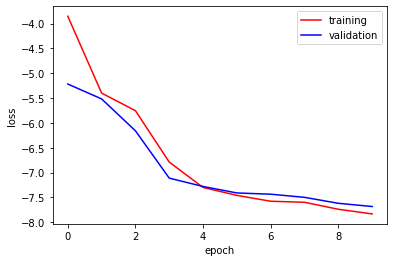

CA


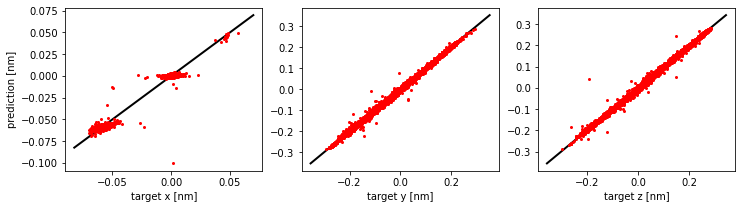

x: r2 0.9549347378414419 slope 0.9727285799571214 offset -0.00042795172569786485
y: r2 0.9977979196039052 slope 1.0020267646586565 offset -0.0009187035895393825
z: r2 0.997217491666238 slope 0.9998708917974937 offset -0.0010120676158292957
N


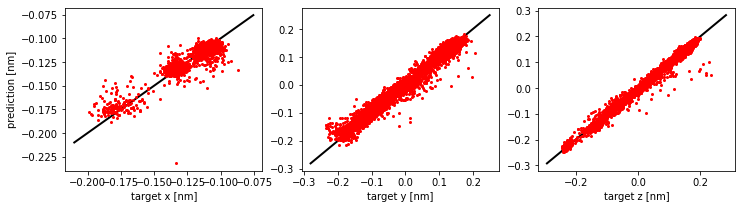

x: r2 0.8867973564404668 slope 0.8748265638473811 offset -0.014789691554151219
y: r2 0.971213666391874 slope 0.9607601297373459 offset 1.4547888578769763e-05
z: r2 0.9871229629113395 slope 0.9899155561582587 offset -0.0024510362104333064


In [42]:
aa='PRO'

# load data for CA-N atoms for proline residues only
[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CAN") 

# initialize model
m = Model1D3_ca_n()
m.apply(m.initialize_weights)
m.zero_grad()

# load partial weights from previous model
# may use other models previously trained 
m.load_state_dict(torch.load('ca_1d3_predict_3.dict'),strict=False)

# disable training of all weights
for param in m.parameters():
    param.requires_grad = False

# reenable training of only the second part of the network that predicts N 
# this means that the CA prediction is not changed during training
for param in m.cn_1.parameters():
    param.requires_grad = True
for param in m.cn_2.parameters():
    param.requires_grad = True
for param in m.cn_3.parameters():
    param.requires_grad = True
for param in m.cn_4.parameters():
    param.requires_grad = True
for param in m.cn_f.parameters():
    param.requires_grad = True   
for param in m.fcn_1.parameters():
    param.requires_grad = True
for param in m.fcn_2.parameters():
    param.requires_grad = True
for param in m.fcn_f.parameters():
    param.requires_grad = True

# optimizer with extra options to only train certain weights
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.001, weight_decay=0.00001)

epochs=10
showoutput=True

# extra options focus training on x coordinates of N atoms (klindex=3)
[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=10.0,klfactor=2.0,klindex=3)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_predict.dict")


We now extend training using more amino acids, reduced learning rate, and slightly less emphasis on x coordinates.

0 0.00047649557016714674 0.00017289050945340324
1 0.0001553366207019487 0.0001361223145612629
2 0.00013535724101688786 0.0001219915459348961
3 0.00012293776528890486 0.00014715295703691402
4 0.00012094233658212526 0.00011052262885082586
5 0.0001167596919476319 0.00010095944587738595
6 0.0001138267520671267 0.00010765738461657037
7 0.00011269844596693089 0.00011303542552343065
8 0.00011221483692564437 0.00010030796838701199
9 0.00010855141847941406 0.00011259305677480983
10 0.00011017954709159829 9.603912786749453e-05
11 0.00010814052875820694 0.00010675175975544938
12 0.00010599996436435087 0.00010059322538484858
13 0.00010920290692986953 9.362548924713374e-05
14 0.00010636717161899799 0.00011576619804590985
15 0.00010184986118021864 9.037944368449435e-05
16 0.00010358962585857772 0.0001270363206971377
17 0.00010731205263878646 9.164157657474637e-05
18 0.00010252076553945393 9.079115279523682e-05
19 0.00010138468175829595 0.00012253683498872245


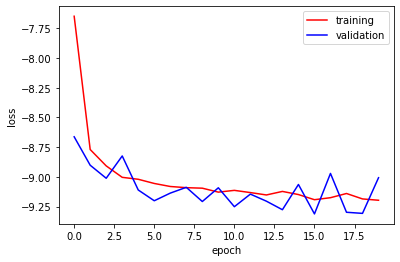

CA


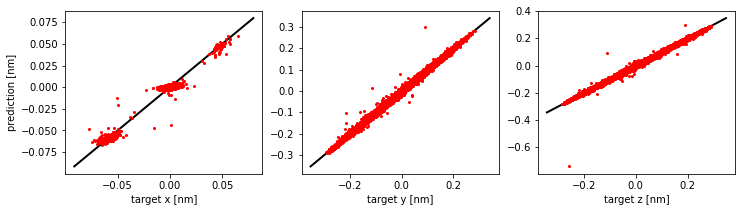

x: r2 0.9163385601774297 slope 0.9187963936460486 offset 0.0003656167176512378
y: r2 0.9993299816703064 slope 0.99995596908007 offset -5.306307862987247e-05
z: r2 0.9978422373352304 slope 1.0008169832223435 offset -0.0006160271983946565
N


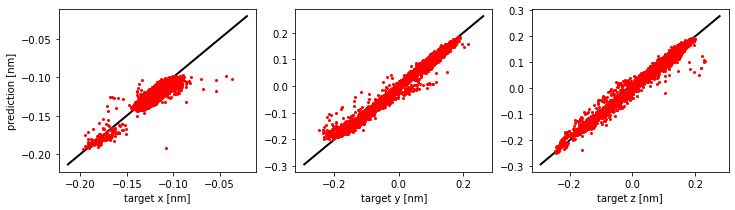

x: r2 0.9227713766365824 slope 0.9032562706503128 offset -0.014185912784123844
y: r2 0.9971248805226163 slope 0.9846597860694403 offset -0.0016898881229787804
z: r2 0.9947680865854884 slope 0.983153857381963 offset 0.003317665057089356


In [43]:
aa='PRO:ALA:VAL:LEU'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CAN") 

epochs=20
showoutput=True

opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0005, weight_decay=0.00001)

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=1.0,klindex=3)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_predict.dict")


One more round with lower learning rate, reduced emphasis on x coordinates, and additional amino acids.

0 4.193599865111854e-05 4.032062600414442e-05
1 3.875268025898441e-05 3.973132824466624e-05
2 3.744018334177623e-05 3.8001959740636496e-05
3 3.5993995893409534e-05 3.803658939712551e-05
4 3.530710988406692e-05 3.83675975716921e-05
5 3.4566188047908477e-05 3.816369024397731e-05
6 3.3831708302993015e-05 3.461409139080496e-05
7 3.3290694732589946e-05 3.399717671994263e-05
8 3.280873099709479e-05 3.8243272437526396e-05
9 3.227236406679702e-05 3.5095561461440805e-05


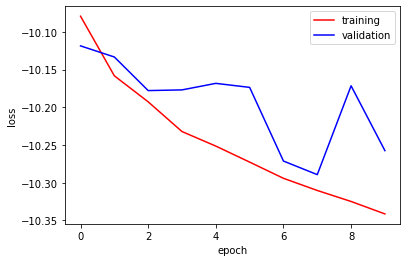

CA


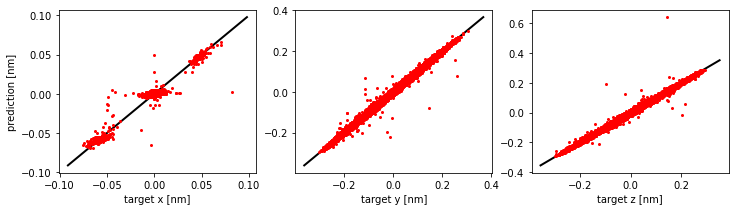

x: r2 0.8650685535596239 slope 0.8703520791435889 offset 0.0004483105095208197
y: r2 0.9992039586715458 slope 1.0004504477166336 offset 8.442384975192174e-05
z: r2 0.9978180399677037 slope 1.0006873459489614 offset -0.0005082099697663461
N


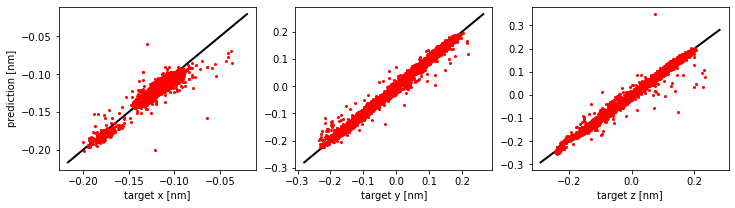

x: r2 0.9423285390233828 slope 0.9581776968393626 offset -0.006279941238373513
y: r2 0.9983203293794201 slope 0.9983457259885288 offset -0.0002943156568335284
z: r2 0.9964274159842379 slope 0.9981488015520361 offset 4.103313642995175e-05


In [44]:
aa='PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CAN") 

epochs=10
showoutput=True

opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0001, weight_decay=0.000001)

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0,klfactor=1.0,klindex=3)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_predict.dict")


We now use the trained CA-N model and add predictions of C/O atoms.

We start with proline and alanine:

0 0.012398460115117457 0.004685643696690132
1 0.003652308650515219 0.0034975660609327113
2 0.00278649667183621 0.003017232583639354
3 0.002400766430375508 0.0035299149965085028
4 0.0021995304659291914 0.003172505274305792
5 0.0020228066942890328 0.001532465309060026
6 0.0019475860024590187 0.001695733919428205
7 0.0019105035300319424 0.0019676263109767067
8 0.0018313709702460637 0.001855066675715057
9 0.0017685814815148993 0.002283827213363201


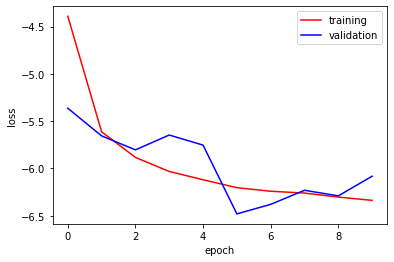

CA


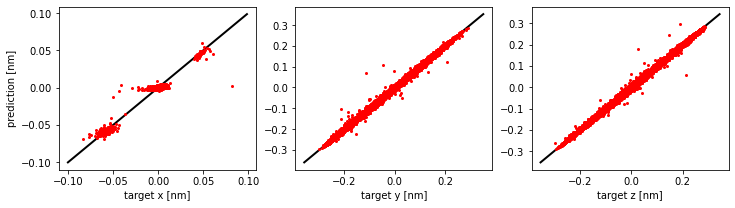

x: r2 0.9292601700244378 slope 0.9314977116822355 offset 0.00032344781170983025
y: r2 0.9991876268330093 slope 0.9999696653082915 offset -9.432010888853204e-05
z: r2 0.9982162710582742 slope 0.9996636316281421 offset -0.00044952584753485403
N


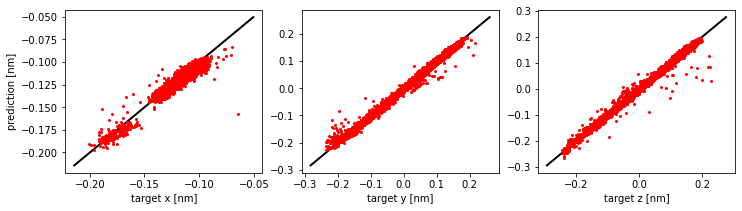

x: r2 0.9534282593720789 slope 0.9740083893755948 offset -0.004626237666056562
y: r2 0.9980960034190478 slope 0.9952852667299983 offset -0.00033883129478665813
z: r2 0.9961719604839355 slope 0.993912564060265 offset -8.890501917792164e-06
C


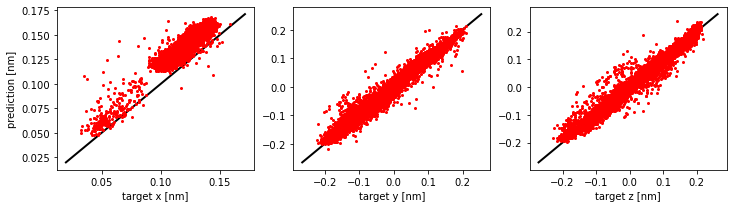

x: r2 0.8870400969501627 slope 1.0094282624384374 offset 0.01725435933422821
y: r2 0.9888652693287666 slope 0.9955962604628054 offset 0.0028217691875372514
z: r2 0.974420635519851 slope 0.9780700236371234 offset 0.00041925833814340785
O


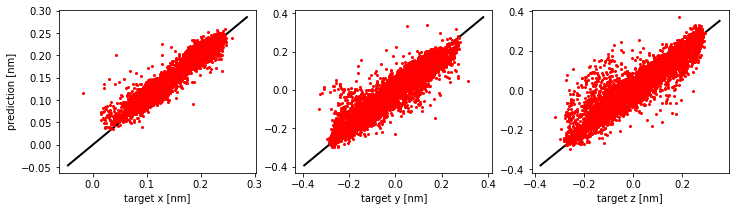

x: r2 0.9572618797253205 slope 0.945166895916443 offset 0.013087422650530617
y: r2 0.9543662342798213 slope 0.9437146916722912 offset -0.002711112601867946
z: r2 0.9113850731057715 slope 0.8994267355432495 offset 0.01231740153793362


In [45]:
aa='PRO:ALA:VAL'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_predict.dict'),strict=False)

for param in m.parameters():
    param.requires_grad = False

for param in m.cco_1.parameters():
    param.requires_grad = True
for param in m.cco_2.parameters():
    param.requires_grad = True
for param in m.cco_3.parameters():
    param.requires_grad = True
for param in m.cco_4.parameters():
    param.requires_grad = True
for param in m.cco_f.parameters():
    param.requires_grad = True   
for param in m.fcco_1.parameters():
    param.requires_grad = True
for param in m.fcco_2.parameters():
    param.requires_grad = True
for param in m.fcco_f.parameters():
    param.requires_grad = True

opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.001, weight_decay=0.00001)


epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=5.0,klfactor=1.0,klindex=6)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict.dict")


We continue training with more amino acids and lower learning rate.

0 0.0025604990005738738 0.0025365729821649335
1 0.0025074990085136163 0.0024869701079106516
2 0.0024842716427983264 0.0022826712266515734
3 0.0024661277496112297 0.0021425332132325565
4 0.002453126436660057 0.0026795880728405995
5 0.0024463482298401756 0.002733786402712035
6 0.00243945211630815 0.0025914419137621253
7 0.002433640430611906 0.0021712433797862383
8 0.002428013044849631 0.0025628707992211078
9 0.002423439846160956 0.002844496981651502


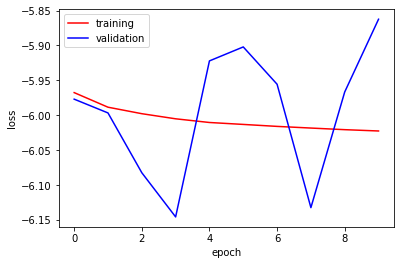

CA


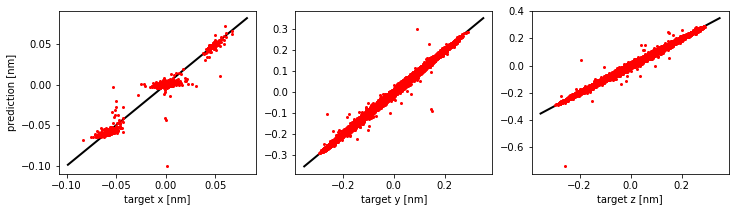

x: r2 0.870940907843395 slope 0.878610502546493 offset 0.0004372549353065878
y: r2 0.9992468973510966 slope 1.0003872330508283 offset 5.7665186057848095e-05
z: r2 0.9979067016669337 slope 1.0008175899215472 offset -0.0004951561596249782
N


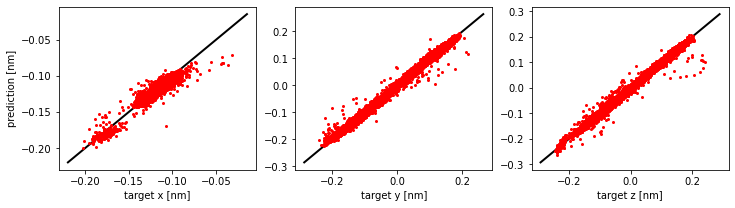

x: r2 0.9454423362615375 slope 0.95832249071093 offset -0.0062588017387112255
y: r2 0.9983370237917362 slope 0.9982989233746504 offset -0.00025768958781782064
z: r2 0.9967975020052185 slope 0.9980888942658801 offset 6.635850103392255e-05
C


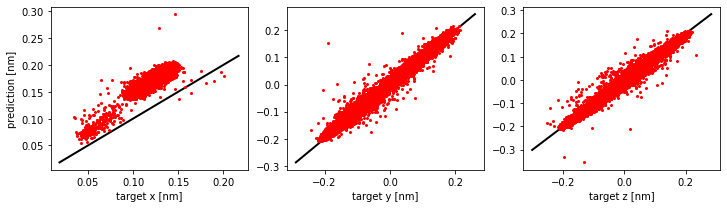

x: r2 0.8722322634738444 slope 1.1415411001307256 offset 0.03156207864135807
y: r2 0.99450105303467 slope 0.9957966842135699 offset 0.003559472130312026
z: r2 0.9887822272900343 slope 0.9946942594112372 offset -0.0017790542120412409
O


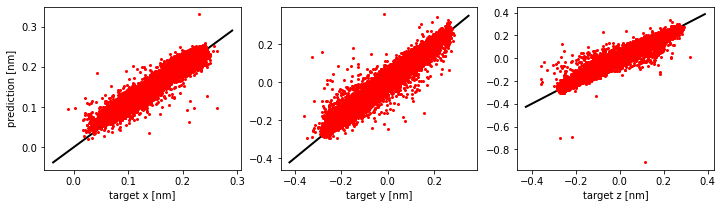

x: r2 0.9615927214290482 slope 0.9182877098071572 offset 0.016432256541460133
y: r2 0.9805450985373926 slope 0.9782536725199851 offset 0.0045075424109038975
z: r2 0.9663361001360966 slope 0.9675598024516597 offset 0.004123137723026624


In [46]:
aa='PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0,klfactor=0.8,klindex=6)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict.dict")


Let's now further train separate models for individual amino acids. 

In these models, all weights are allowed to change to obtain optimal models.

0 0.0007511951458361706 0.000208705869123658
1 0.00019408815282848522 0.00018662461692647394
2 0.00018127414946458444 0.00018103897702272443
3 0.00017817923468431798 0.00017980604437017146
4 0.00017704482844706172 0.00018819024351929595
5 0.00017375694358523822 0.00017644005265470683
6 0.0001728097971257133 0.00018075030591561652
7 0.0001725855058104957 0.00017791485359803136
8 0.00017485872200323325 0.00017958797436313742
9 0.00017056445336272714 0.0001858162690671255


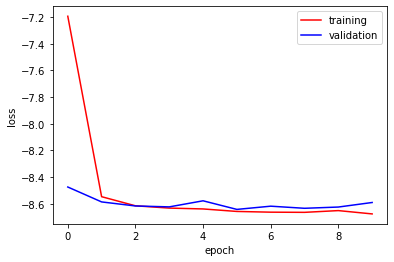

CA


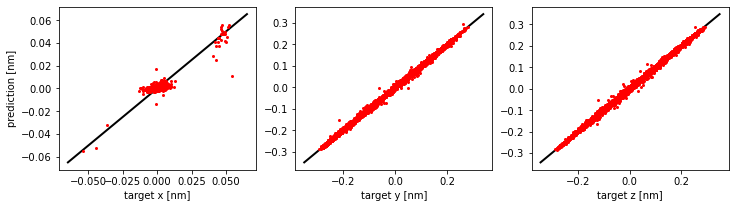

x: r2 0.7311714294861418 slope 0.7171789496466542 offset 0.00036182247078590443
y: r2 0.9993234064085053 slope 0.9963765481754602 offset -0.000740608214378255
z: r2 0.9980174356386095 slope 0.9980836650779629 offset 0.0009654718643408277
N


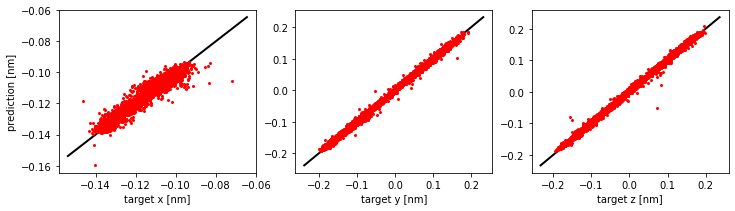

x: r2 0.9424842291584463 slope 0.9554911106117434 offset -0.004461666207350806
y: r2 0.9985955352732914 slope 0.9942349320193042 offset 0.0006237707075634896
z: r2 0.9971670929670479 slope 0.9986353529249803 offset 0.0031879599751685056
C


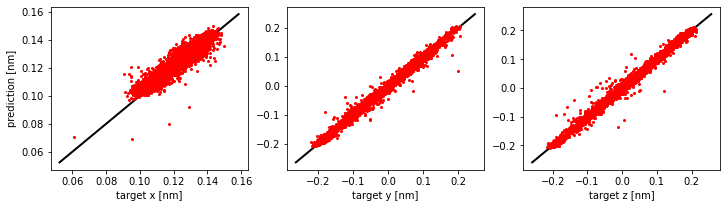

x: r2 0.8682203639535542 slope 0.8927652418039025 offset 0.014703348192692811
y: r2 0.9957131664450696 slope 0.990048424816997 offset -0.000287647583102818
z: r2 0.989235362751089 slope 0.9966542484787736 offset 0.0009919126355953205
O


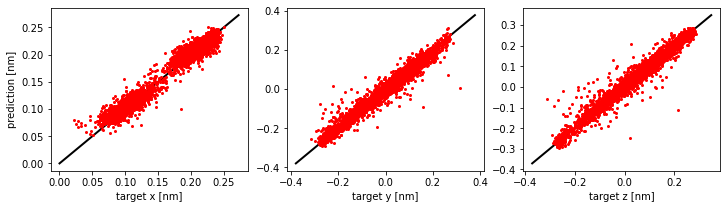

x: r2 0.9699542077481121 slope 0.9700406462867058 offset 0.00764052512188268
y: r2 0.98455499754822 slope 0.9689530536608503 offset -0.002841603172149876
z: r2 0.9701292186939553 slope 0.9760904880023648 offset 0.005168108444064637


In [47]:
aa='ALA'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")


0 0.0008519918075242978 0.00023369469065584082
1 0.00020119474980414713 0.00018890046571695446
2 0.0001851473921955663 0.0001840375696416442
3 0.00017999199735641014 0.00017794690543797357
4 0.00017846887411516427 0.00017709721939508516
5 0.0001762484064654148 0.00017537661392124946
6 0.0001717710843617429 0.00017006518710977877
7 0.00017232130448974203 0.00017256829393323117
8 0.00016950857856759934 0.00018863278364685825
9 0.00017440988033610796 0.0001750460625279686


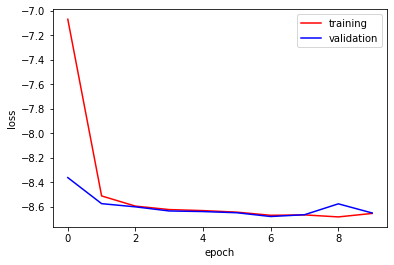

CA


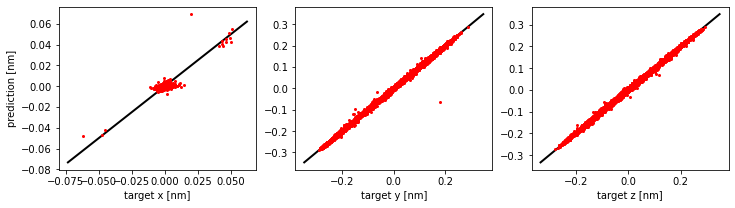

x: r2 0.6003455097132855 slope 0.6435933109700381 offset -0.00016065360458543079
y: r2 0.9992455126501328 slope 1.001424245284777 offset 0.00025021860856486514
z: r2 0.9980165775018388 slope 0.994106059669172 offset 0.0014217808934617543
N


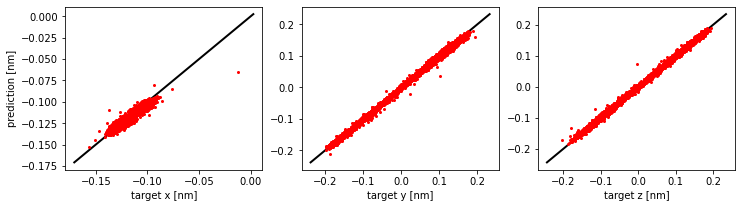

x: r2 0.9361343159048622 slope 0.9247840268560398 offset -0.009608823200110195
y: r2 0.9986097826347871 slope 1.0018345650700242 offset -0.0007511011329698024
z: r2 0.9974688945387495 slope 0.9904110498185645 offset 0.0010186186281843932
C


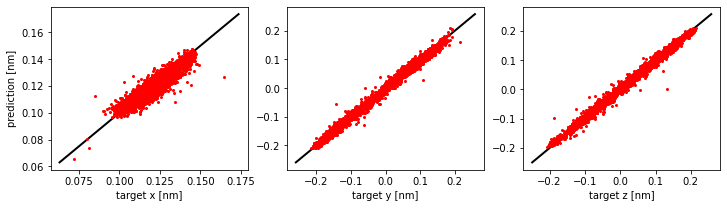

x: r2 0.8322423143197869 slope 0.8579167737246585 offset 0.01577525731373286
y: r2 0.9965170365436041 slope 0.993084861136046 offset -0.0012233868712314792
z: r2 0.9912085844976811 slope 0.980135902185876 offset 0.0018297644813653306
O


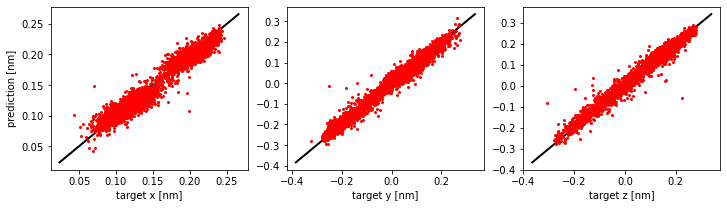

x: r2 0.9567039454975077 slope 0.9719495399913405 offset 0.0023356922937509406
y: r2 0.9872684670157449 slope 0.9770761821269236 offset -0.001950889999478303
z: r2 0.9751434779432041 slope 0.959389125725258 offset 0.007011518934833719


In [48]:
aa='VAL'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")


0 0.0007214760086023655 0.0002548569288742406
1 0.00021088105654278378 0.00023296266695037925
2 0.00019849360404818148 0.0002259964534335242
3 0.00019346625653987514 0.00022353772648130653
4 0.0001928733264565022 0.00022141874137255853
5 0.00019221484716850477 0.0002272760991213049
6 0.00018920692099540324 0.00022242387819072738
7 0.00018768061159841034 0.00022048990410047657
8 0.00018746637420328726 0.00022333325667687063
9 0.00018998125299949094 0.00023024847295899717


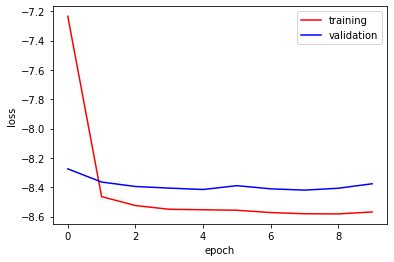

CA


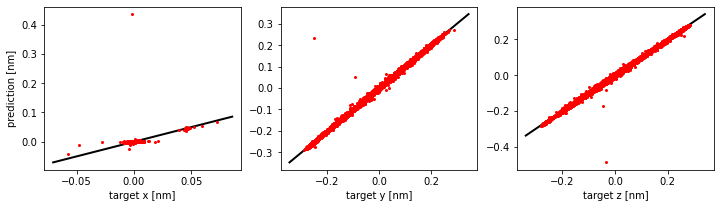

x: r2 0.10618029334931434 slope 0.5715672486897647 offset -0.0001651357579943995
y: r2 0.9987406382409532 slope 1.0037163282042818 offset 0.0010222851514415515
z: r2 0.9963986754949958 slope 1.0004062617383396 offset -0.0008644283352222386
N


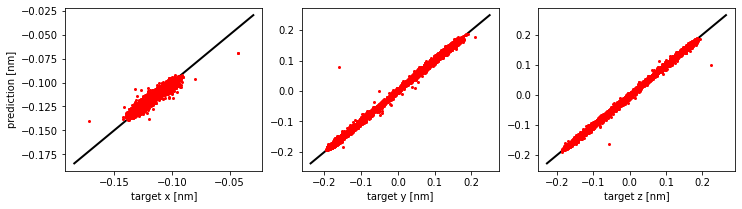

x: r2 0.9412207187978352 slope 0.9107252261747892 offset -0.009965072390970942
y: r2 0.9984020199910597 slope 1.0073589484536194 offset 0.0012910763812445727
z: r2 0.9975473679747896 slope 1.0021816791984663 offset -0.0013789951176374077
C


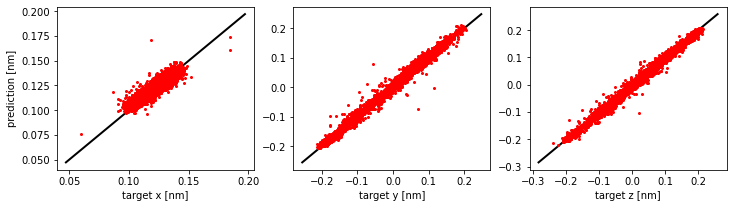

x: r2 0.8437239602809352 slope 0.8312638929193483 offset 0.02086510282113141
y: r2 0.9960385396082975 slope 1.0059666109560288 offset 0.0032899811873701307
z: r2 0.9913997274702615 slope 0.997785680902911 offset -0.00146883329811048
O


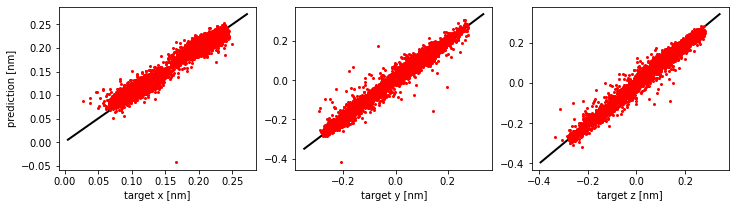

x: r2 0.958552446038069 slope 0.937874124523757 offset 0.011529615969297441
y: r2 0.9847696409125368 slope 1.003290944031879 offset 0.005182743689842062
z: r2 0.976069699760886 slope 0.9885959435058257 offset -0.0017089553857201206


In [49]:
aa='LEU'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")


0 0.0011041034589046224 0.00033589118306006954
1 0.0002787676045651703 0.0002736724237409114
2 0.0002518489042510434 0.00026397298090605247
3 0.0002460568105864998 0.0002594847666305514
4 0.00024140968192417253 0.0002563562530928142
5 0.00023925288557317495 0.0002581560417290671
6 0.00023728721953375498 0.00025281927845975405
7 0.00023331280499405693 0.00025387361176354184
8 0.00022926482051843777 0.0002507525720028572
9 0.00023058283356173584 0.0002527421475959419


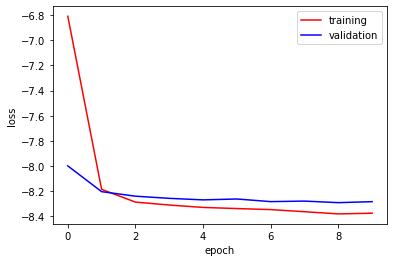

CA


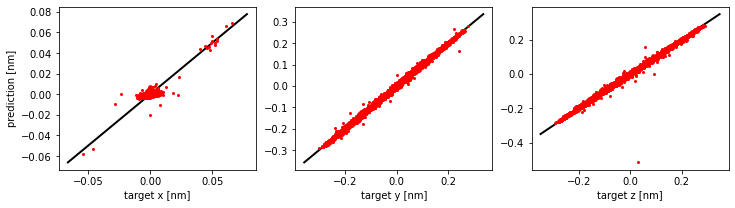

x: r2 0.6806493883559736 slope 0.708672907362106 offset -1.680237571921048e-05
y: r2 0.999035010610774 slope 0.9999740998853366 offset 0.000308597174859343
z: r2 0.9954335826564783 slope 0.9914508783968891 offset 0.0006078266967716886
N


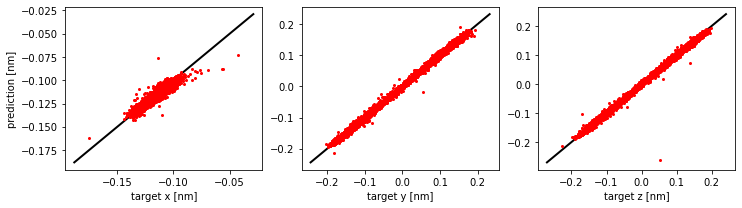

x: r2 0.931689587874773 slope 0.923606939007635 offset -0.009536177590931838
y: r2 0.998350177767709 slope 1.0035414381157504 offset 0.0011233469372543617
z: r2 0.9955866145242189 slope 0.9898792684797211 offset 0.00016340909605021617
C


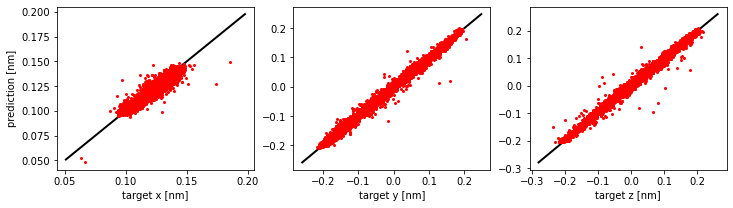

x: r2 0.8813132680077832 slope 0.8897376708358027 offset 0.012774435068445694
y: r2 0.9945786621098157 slope 0.9898010140261435 offset 0.00012624244338470259
z: r2 0.9901034783044127 slope 0.9796500560514017 offset 0.0021902609702888695
O


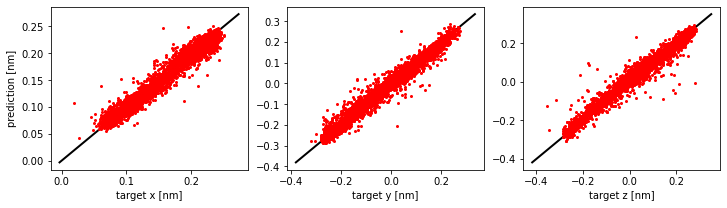

x: r2 0.9637217793773774 slope 0.9608784822115441 offset 0.004558365071701986
y: r2 0.9824160024990354 slope 0.9716262632124718 offset -0.0004737730673809448
z: r2 0.9731138515830691 slope 0.9590824870114958 offset 0.0060052578464622475


In [50]:
aa='ASP'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")


0 0.001400097225753901 0.00046296835448736607
1 0.0002982668462209404 0.00024551357525448054
2 0.00023113981975863377 0.0002249950952314634
3 0.0002159700282694151 0.00021972966798349095
4 0.00021128290439567838 0.00022096355725773122
5 0.00020467419817578049 0.00020936108051735353
6 0.0001995270897168666 0.00020540062331117476
7 0.00019980357610620557 0.00021188425464027815
8 0.00019762176768078158 0.00020720917854200022
9 0.00019596686470322311 0.0002088605503262707


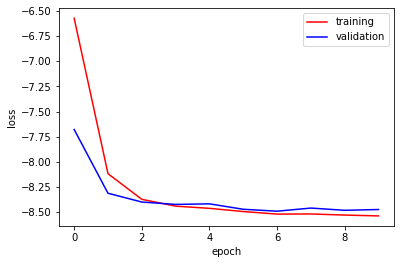

CA


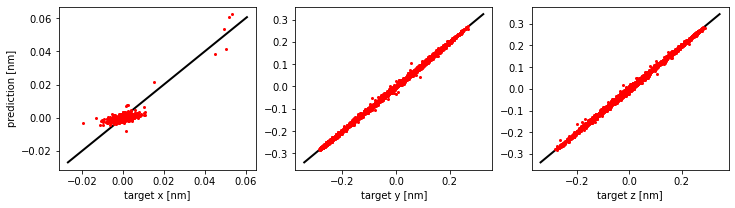

x: r2 0.586634512234061 slope 0.5965124449658986 offset -0.0001506005819053991
y: r2 0.9993366425061498 slope 0.9987123818648147 offset -0.0005237481838468033
z: r2 0.9979394541466228 slope 0.9997008003558662 offset -0.0003622803039845133
N


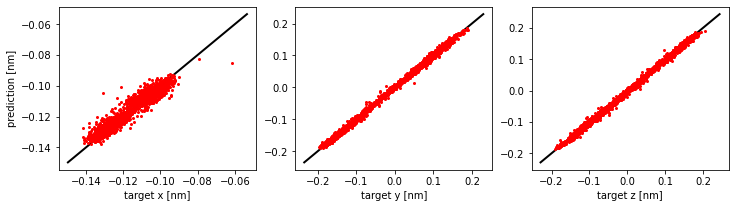

x: r2 0.9300667112341677 slope 0.9079296577244731 offset -0.010124279540473805
y: r2 0.9985965237078822 slope 0.9981338277332091 offset 0.0006806498089161062
z: r2 0.997286117213474 slope 0.9985575004987824 offset -0.0013617576646798892
C


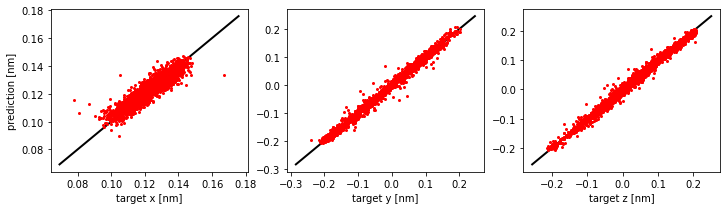

x: r2 0.8454784763485625 slope 0.837715356793909 offset 0.01982308768596594
y: r2 0.9951252697389346 slope 1.0013623757874945 offset 0.0011698206240319114
z: r2 0.9897631006687918 slope 0.994455958919077 offset -0.0010060674542610934
O


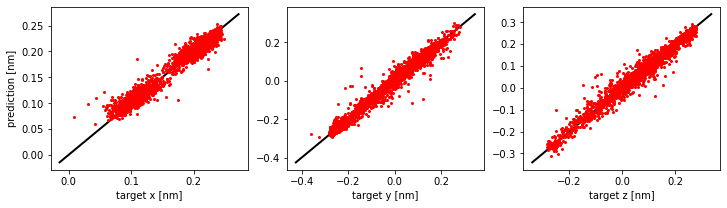

x: r2 0.961185009693865 slope 0.9372944627748223 offset 0.01125546621359505
y: r2 0.9830839595379482 slope 0.9883407091634089 offset 0.00022253968547672476
z: r2 0.9710834915641209 slope 0.96967454075722 offset 0.003136566436622551


In [51]:
aa='GLN'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")


0 0.0009407006805036765 0.0002726575056465798
1 0.00022373922076761066 0.0002323421419853222
2 0.0002036860858103918 0.00022529746361652116
3 0.00019679684962337727 0.00022070862330978583
4 0.0001931520682239138 0.000222108299745248
5 0.0001919320299445341 0.00021837113636509727
6 0.00018979363227902236 0.0002207181294405949
7 0.0001895135047722279 0.00021882924574363603
8 0.00018948702485181902 0.00021653416584362678
9 0.00018505511980038136 0.00022447801623217664


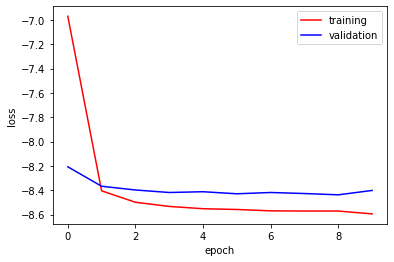

CA


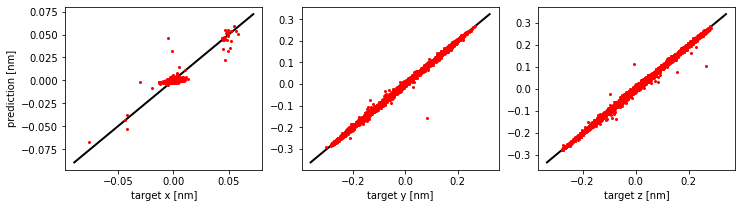

x: r2 0.7481477837756889 slope 0.7624541524492594 offset -5.0713559831706465e-05
y: r2 0.9988769841792327 slope 1.0009612549735727 offset 0.0008202346441477659
z: r2 0.9973082310309779 slope 0.9967391227269213 offset 8.669977470902174e-05
N


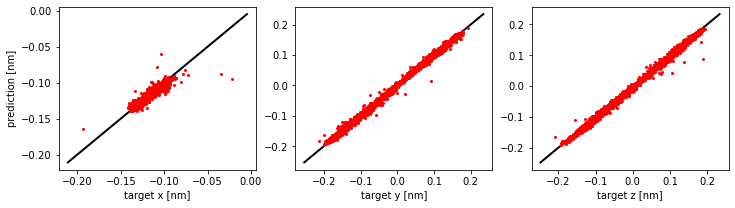

x: r2 0.9253270998250904 slope 0.9248439921432937 offset -0.00910887110872094
y: r2 0.9983308695961217 slope 0.998180861100674 offset 0.001019349503113054
z: r2 0.9970811138855873 slope 0.995673006826874 offset -0.0021181303226727524
C


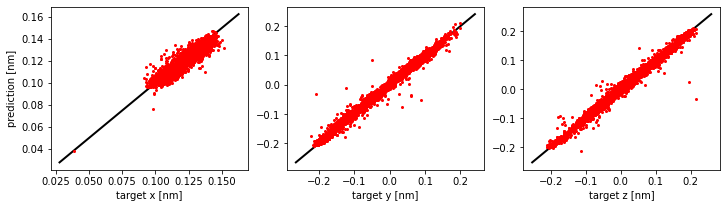

x: r2 0.8548687606423987 slope 0.8823974483435385 offset 0.013101131489638304
y: r2 0.9942497213464463 slope 0.995027677819865 offset 0.001321766539177982
z: r2 0.9878672725151355 slope 0.9860927256126841 offset 0.0008652281632714025
O


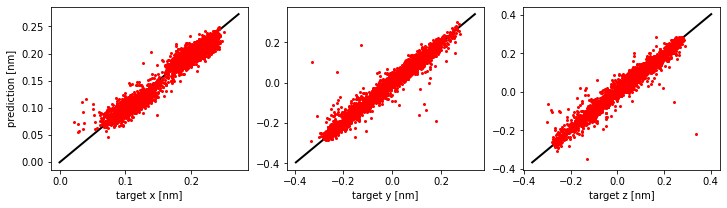

x: r2 0.9621552047455805 slope 0.9691592211666159 offset 0.0023403279019311996
y: r2 0.980968427652142 slope 0.9835325384692566 offset 0.001025274341019053
z: r2 0.9675513747530803 slope 0.9638983698210174 offset 0.004762654554727741


In [52]:
aa='GLU'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")


0 0.0024420909422378126 0.0008816438940558918
1 0.0007707358499129231 0.00042380315762174996
2 0.000428666329333702 0.00035527365557098484
3 0.0003255729232198344 0.0003099644210748496
4 0.00029462815235512186 0.00027740743303110736
5 0.0002723478974075988 0.0002625451677957504
6 0.0002676201223109204 0.00025681603657040354
7 0.0002584552208785541 0.000250894987016826
8 0.0002488817173378685 0.0002467337235635128
9 0.0002509329239658725 0.00025302989659015807


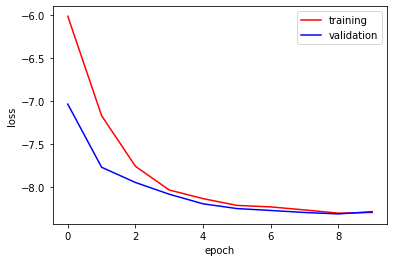

CA


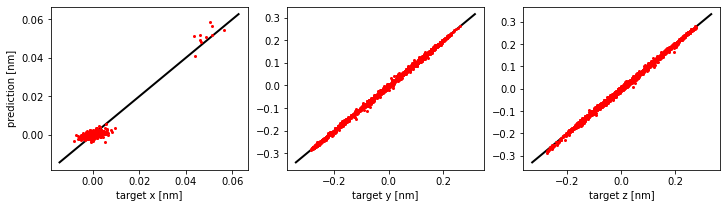

x: r2 0.8627912587197113 slope 0.9117972328354006 offset 0.0002142686039643688
y: r2 0.9991531220904308 slope 0.9959677251889124 offset -0.0011403678370994347
z: r2 0.9978823468624947 slope 1.0001076455470892 offset -0.00029208785282771287
N


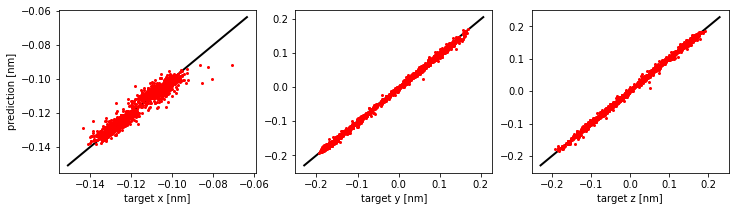

x: r2 0.9296849055952174 slope 0.9254044936993263 offset -0.00848632359234805
y: r2 0.9983475717735053 slope 0.9912967607406196 offset -0.0020132575785843515
z: r2 0.996997097271609 slope 1.0044398312364382 offset 0.0015629445573235791
C


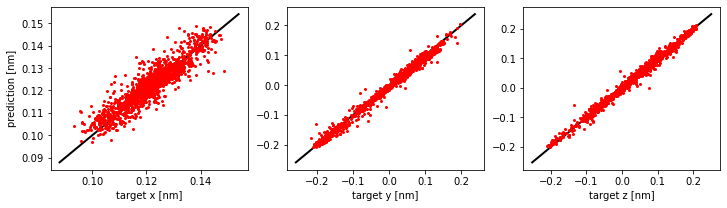

x: r2 0.8287835688424245 slope 0.883830554206157 offset 0.015170089562191028
y: r2 0.9934726350857938 slope 0.9826895138643247 offset -0.003703464812695373
z: r2 0.9882419148013647 slope 0.982269753188653 offset 0.0007888501758261182
O


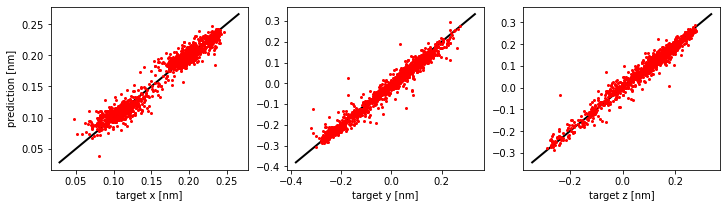

x: r2 0.9573974315035014 slope 0.9565381115107819 offset 0.008123685662513036
y: r2 0.9762403477566529 slope 0.9623183109737683 offset -0.008946598505056677
z: r2 0.9659692928967109 slope 0.9578675840752995 offset 0.0031153660163107666


In [53]:
aa='TRP'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")


0 0.001045443266169362 0.00030561123500674823
1 0.00026981385750938597 0.0002590507915640289
2 0.0002463905669477147 0.00025086173310332903
3 0.0002367490023971186 0.0002514659447121218
4 0.00023486383512742273 0.00024760272753197225
5 0.00022871579828157942 0.00024357662656090075
6 0.00022637377302695919 0.00024016770274458378
7 0.00022560440781186722 0.00024334573657727192
8 0.0002290835394281506 0.00024433611571166453
9 0.000226669716842783 0.0002539737741303777


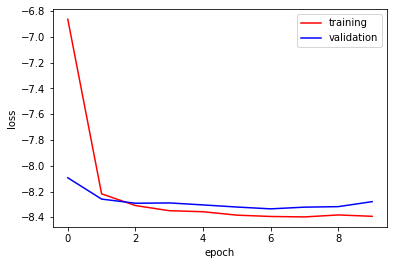

CA


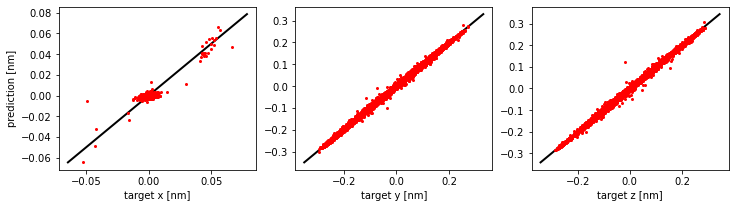

x: r2 0.7564708451507907 slope 0.7606642207752442 offset -0.0006273750537493931
y: r2 0.9989032148182044 slope 0.9980823884393171 offset 3.952757059166867e-05
z: r2 0.9976358740594601 slope 0.9990803755745155 offset 0.0005746384448183754
N


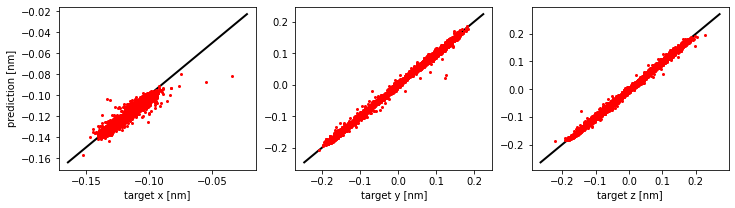

x: r2 0.9409062313973015 slope 0.9372873787904066 offset -0.008668449077959023
y: r2 0.9980312642101407 slope 0.9982956547948284 offset -5.405205943568442e-05
z: r2 0.9967376219792711 slope 0.9968494663841004 offset -0.00028721858743564754
C


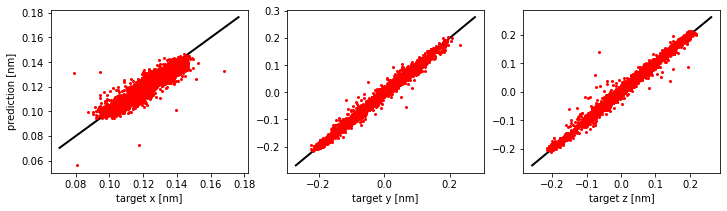

x: r2 0.8822560183955542 slope 0.8964548617929559 offset 0.010896053322003205
y: r2 0.9936591098348069 slope 0.9900302442399034 offset -0.001522612262841054
z: r2 0.9871276976077771 slope 0.9927188572840777 offset 0.0023720225942289487
O


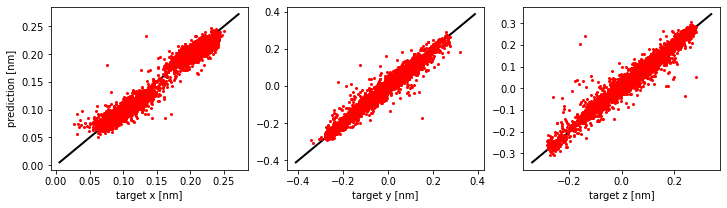

x: r2 0.970632455564587 slope 0.9743573200071671 offset 0.0011403067333913275
y: r2 0.9777496376366368 slope 0.9750190852563647 offset -0.002149867027816013
z: r2 0.960200888668121 slope 0.9626829415460721 offset 0.006411786005859302


In [54]:
aa='SER'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")


0 0.0010732389436776024 0.0003121369063544119
1 0.000263086205167282 0.00023215120964342298
2 0.00023601376548564683 0.00022295791815034379
3 0.00022819512362022782 0.00021743836168203884
4 0.00022348201730185084 0.00021273076110048554
5 0.00021862361399042936 0.0002174203141420559
6 0.00021766060542884386 0.0002212489254719389
7 0.00021575064941619832 0.0002072512891115285
8 0.0002100638611914797 0.00021756406994211043
9 0.0002171438653022051 0.00021668075808165964


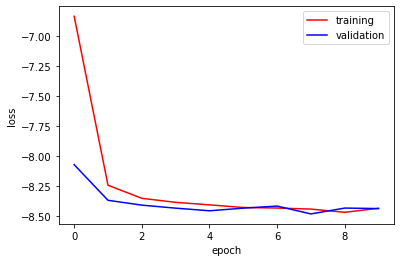

CA


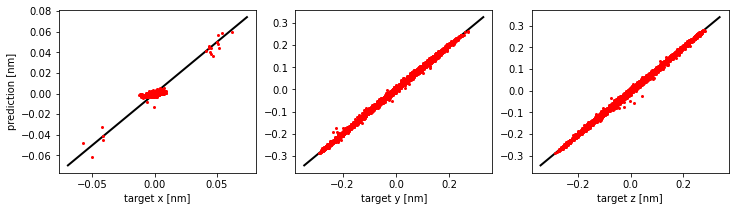

x: r2 0.7449416025355728 slope 0.7340480889044282 offset -0.0001083104986321933
y: r2 0.9990710036796011 slope 1.0027023881202624 offset 0.0014345643293906113
z: r2 0.9980629509655176 slope 1.0003585488577005 offset 0.00025315542870140567
N


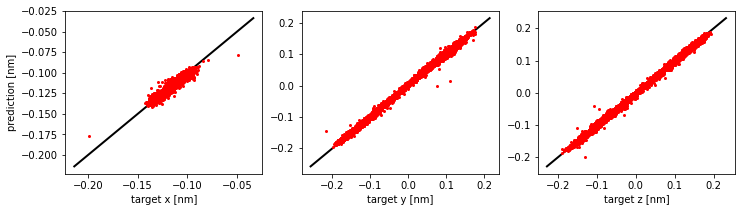

x: r2 0.9478125594316356 slope 0.9556150957917083 offset -0.005670568484853117
y: r2 0.9978946085116566 slope 1.0049229841287406 offset 0.0026709556423121367
z: r2 0.9967939994474042 slope 0.9982260644450419 offset -0.0007668491601384043
C


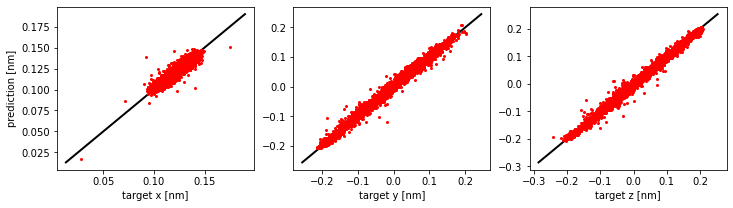

x: r2 0.8909282502536907 slope 0.9220796807711715 offset 0.008912384870703782
y: r2 0.9940208096159516 slope 1.0005744218999404 offset 0.0030815360901237585
z: r2 0.989917796495235 slope 0.9934888846091962 offset -0.0012147453832765977
O


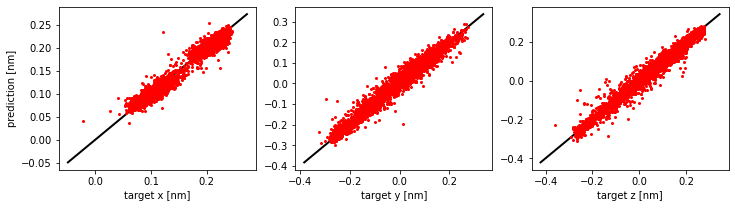

x: r2 0.9710219013728538 slope 0.9727258435175992 offset 0.002459221168581327
y: r2 0.980100918122158 slope 0.989757475470283 offset 0.00474916328361398
z: r2 0.9709405693824519 slope 0.9778279573241319 offset -0.0011665157660769587


In [55]:
aa='THR'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")


0 0.001401823544357386 0.0004497355202808806
1 0.0003350367458349663 0.000321022153743037
2 0.00028712246178959805 0.00030289741683706877
3 0.000276128279236016 0.0002933228272367309
4 0.00027068362639208016 0.00029494407383103596
5 0.00026618786392241926 0.0002916299062194317
6 0.0002641139682155982 0.0002836529365298036
7 0.0002611030306272571 0.00027813057117717557
8 0.00025822937014810223 0.00028783893051123177
9 0.00025717942359430407 0.0002798071956708259


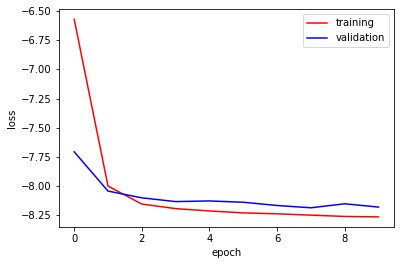

CA


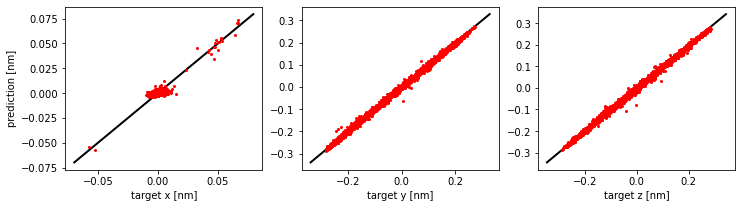

x: r2 0.79086460288998 slope 0.8102362037573552 offset 0.0002941421254893809
y: r2 0.998954335296805 slope 0.9957925395634512 offset -0.00042519796061683823
z: r2 0.998050547509064 slope 0.9901787379770048 offset -0.0005681067472130003
N


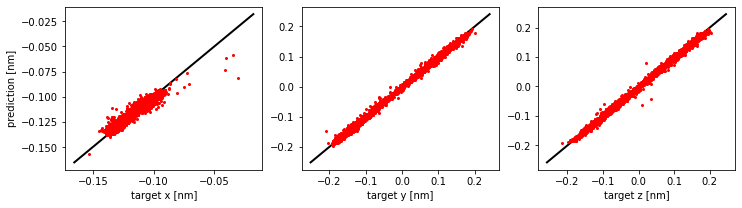

x: r2 0.9238195098107316 slope 0.8840983812469966 offset -0.012859706035962482
y: r2 0.9981122072154447 slope 0.9928131929372342 offset -0.0013715667414078841
z: r2 0.9969036269653845 slope 0.9890859626698724 offset -0.0014597198575601938
C


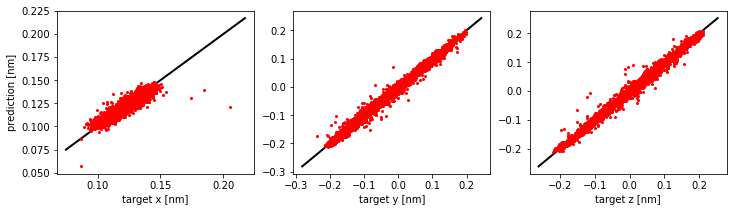

x: r2 0.8623209128318883 slope 0.8534563243019607 offset 0.017718544249371887
y: r2 0.9936218414815438 slope 0.9875786756190071 offset -0.002566874646829684
z: r2 0.9905039429934422 slope 0.9881088789934269 offset -0.0012308688669223633
O


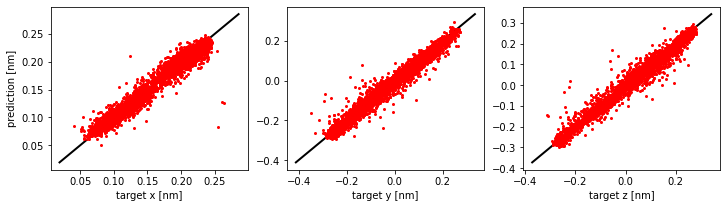

x: r2 0.9579385294249024 slope 0.9467321117554872 offset 0.007972445451519428
y: r2 0.9777238498198034 slope 0.9747439062669236 offset -0.006317441385322961
z: r2 0.9732807335337222 slope 0.9729686582991242 offset -0.003080126869531248


In [56]:
aa='ASN'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")


0 0.0014549418565972397 0.00046557773619176034
1 0.0003477071722348531 0.0003074613075548428
2 0.00028005516796838494 0.0002789432729906637
3 0.0002645338284006963 0.0002668410112883016
4 0.00025414458747642735 0.0002603921361110309
5 0.0002497322760367145 0.00026037355620590457
6 0.0002453541247329364 0.0002701282238792339
7 0.00024291162699228153 0.00025369975903507326
8 0.00023731462036569913 0.0002531111422730596
9 0.00023591232408458988 0.00025495309656128787


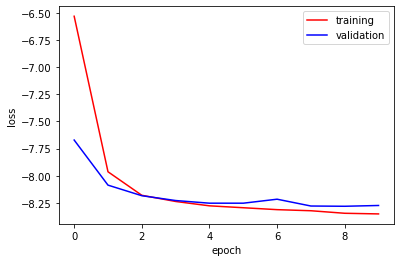

CA


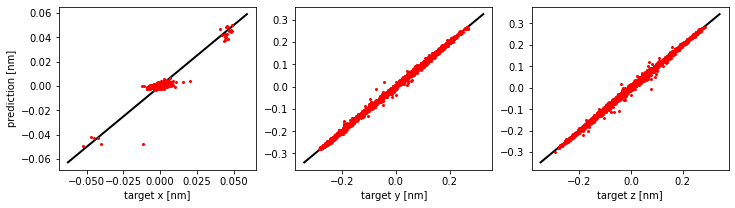

x: r2 0.8078182656910959 slope 0.8028803641327412 offset 0.00039480675876212023
y: r2 0.9991418155222218 slope 1.0001504110095558 offset 0.0008486494739659428
z: r2 0.9970423492695286 slope 1.0024549249326706 offset 0.0006015279498536794
N


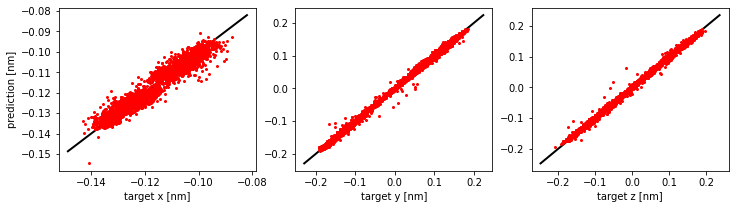

x: r2 0.9336884614229733 slope 0.9397015343231123 offset -0.007014608282897822
y: r2 0.9977801776210186 slope 0.998580827358499 offset 0.0003825425309029115
z: r2 0.9959127645097701 slope 0.9931787154668303 offset 0.0017170271089597539
C


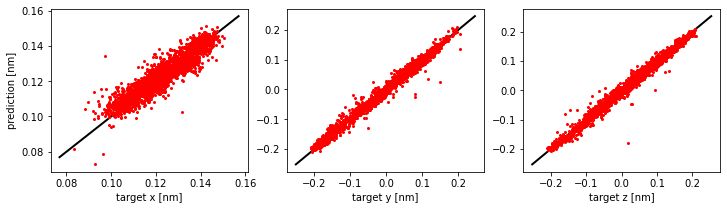

x: r2 0.8497407910044495 slope 0.8747328580233247 offset 0.016096151734476358
y: r2 0.9933529326784661 slope 0.9952708199841964 offset 0.0013714538350650743
z: r2 0.9852270575873558 slope 0.9953444379765511 offset -0.0006516754685037991
O


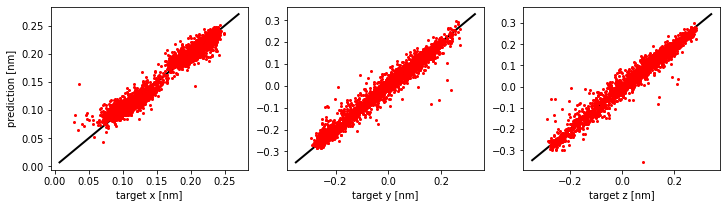

x: r2 0.9596390872715217 slope 0.9570384589648687 offset 0.008265564578385648
y: r2 0.976578999393333 slope 0.9765753811860389 offset 0.00030413859711658775
z: r2 0.9622240255986833 slope 0.9775127303460872 offset 0.0006083534542542096


In [57]:
aa='TYR'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")


0 0.0020514835732204743 0.0005389235644227405
1 0.0005313786233799826 0.00036857926487368853
2 0.00034490477992221713 0.00031397516014278665
3 0.00030375282298528443 0.000296321277202862
4 0.00028847288309694514 0.0002838195647842128
5 0.00027531586697717244 0.00028260739423860757
6 0.0002708971250716499 0.0002764523092276921
7 0.0002670024926038949 0.00027257493470883473
8 0.00026259772743000403 0.00027202903438431784
9 0.0002590243491699527 0.0002742097471542924


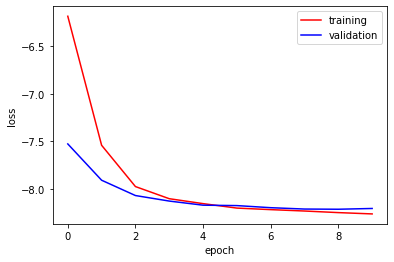

CA


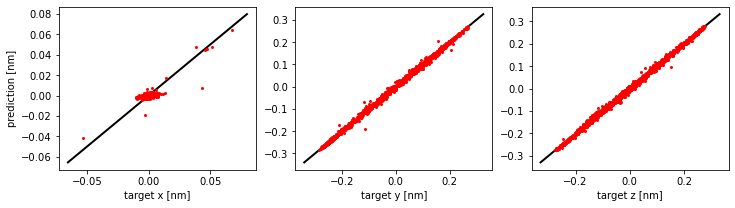

x: r2 0.6736032027095863 slope 0.65703709364643 offset -0.00021103928075447397
y: r2 0.99893545791437 slope 0.9992753649485916 offset 0.0002617873557068384
z: r2 0.9979958357791063 slope 1.0041209383359622 offset 0.00044882054955730326
N


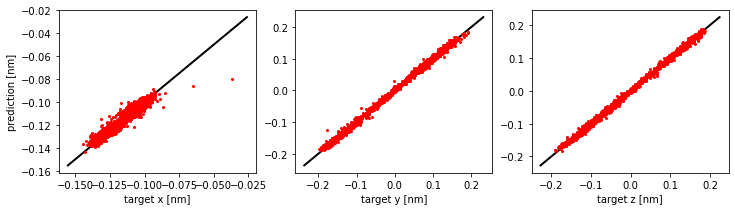

x: r2 0.9282745751177454 slope 0.9257438258786457 offset -0.00795435253653777
y: r2 0.9981226612453474 slope 0.9974384100995535 offset 0.0018721074255449721
z: r2 0.9973527047386721 slope 0.9998548183033396 offset 0.0008468179049471412
C


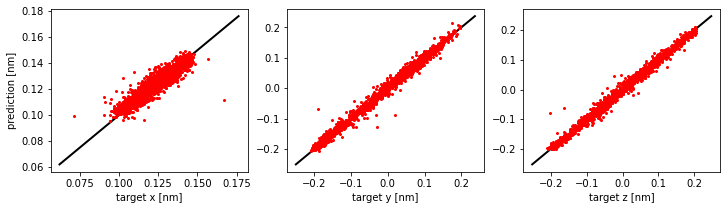

x: r2 0.8461893728715326 slope 0.8647226675854449 offset 0.017445635747506058
y: r2 0.993165502700879 slope 0.99824480603697 offset 0.0016621627679471312
z: r2 0.9890809808993208 slope 0.996620175411286 offset 0.0004838429129149016
O


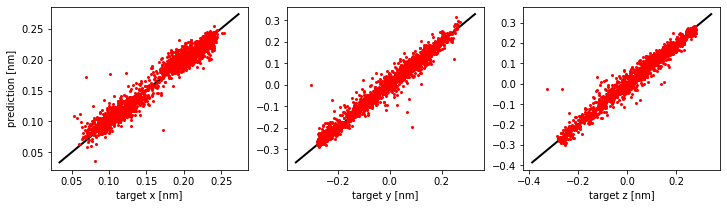

x: r2 0.9566255844316142 slope 0.9488301943277749 offset 0.009616411264905173
y: r2 0.9774395411607011 slope 0.9823606700226483 offset 0.003363545870054288
z: r2 0.9699789496251997 slope 0.9780234088623387 offset 0.0015772362111271948


In [58]:
aa='HIS'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")


0 0.002672827506268566 0.0011042679381222265
1 0.000888244494986297 0.000705953086346677
2 0.0004928311761680313 0.0004340018347811376
3 0.0003757163702340966 0.0003514659625805637
4 0.0003230550051243468 0.0003202056115090801
5 0.00029504771968773144 0.0002990383446044344
6 0.00027838961316526615 0.0002909757259262402
7 0.00027470617814370513 0.00029103616827155023
8 0.00026702125879554927 0.00028179923203274545
9 0.0002633254004070874 0.0002813232733601033


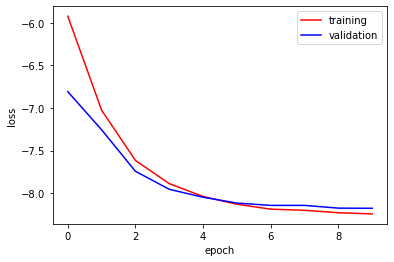

CA


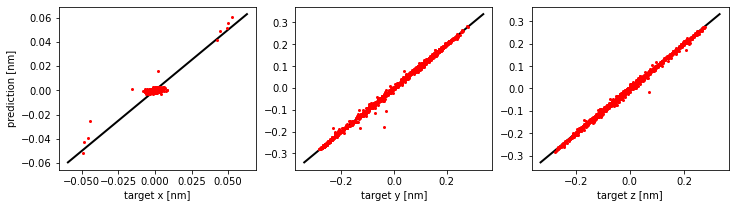

x: r2 0.8017275600448247 slope 0.8140505280887028 offset 3.8666666809729305e-05
y: r2 0.9982647966764748 slope 0.9986617059105096 offset 0.0005340246860536524
z: r2 0.9971022360298046 slope 0.9979927436035725 offset -0.00014081436508163805
N


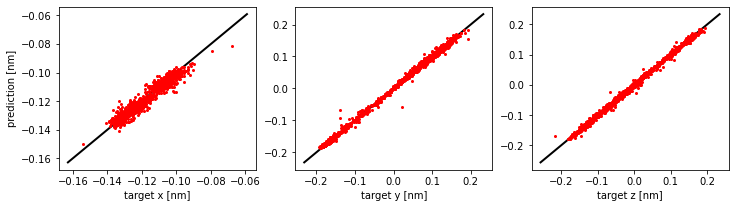

x: r2 0.9344067802824828 slope 0.927070242236943 offset -0.00886482350272702
y: r2 0.9973537371553411 slope 0.9948777700364134 offset 0.0012319646509265578
z: r2 0.9956728974490316 slope 1.0022813957950016 offset 2.6790079511094383e-05
C


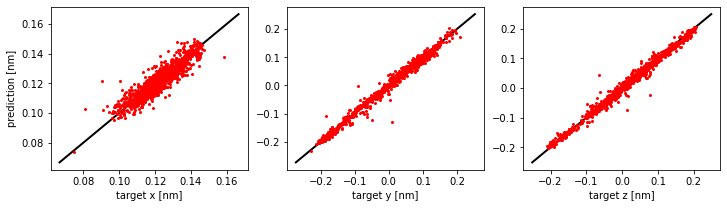

x: r2 0.8319041853718093 slope 0.8960047372334947 offset 0.012326257559349199
y: r2 0.9922487557864821 slope 0.9938404505459828 offset 0.0007068084159217794
z: r2 0.9858453722225431 slope 0.9801445137604546 offset 0.0005082030289204828
O


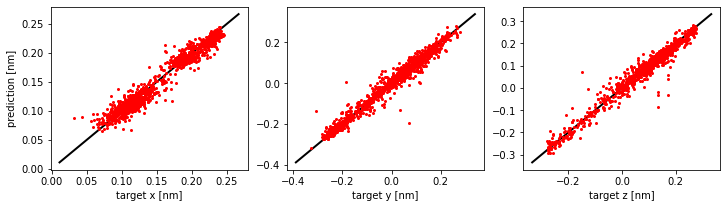

x: r2 0.9548915944054448 slope 0.9504382573600854 offset 0.006741928905192512
y: r2 0.974884368682644 slope 0.9773020922583737 offset 0.0010162889564485356
z: r2 0.9622632863163456 slope 0.9687119476161508 offset 0.0022353540039103253


In [59]:
aa='CYS'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")


0 0.0020007547025349647 0.0007210685431794388
1 0.000502251523464699 0.0003828345517735932
2 0.0003029906913391588 0.000256150571783437
3 0.00024311295676264255 0.00024060953347314066
4 0.0002305273074478678 0.00022907156205653984
5 0.00022067328973207623 0.00022051827408731993
6 0.000212297572836499 0.00021812895525226804
7 0.00021362830097239246 0.000216948290283253
8 0.00021630693706409896 0.00021709452869516778
9 0.00022085723450051292 0.00024690221808917835


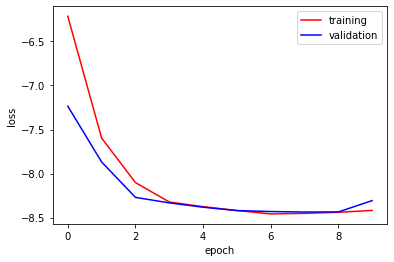

CA


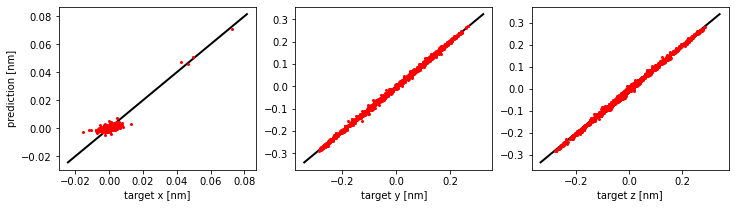

x: r2 0.6959312032531992 slope 0.6882166157609932 offset 0.00015121142921101878
y: r2 0.9993958474536795 slope 1.0025865851926787 offset -0.00026834822394178337
z: r2 0.9974832187565729 slope 1.0069723161013517 offset -0.001361858448651514
N


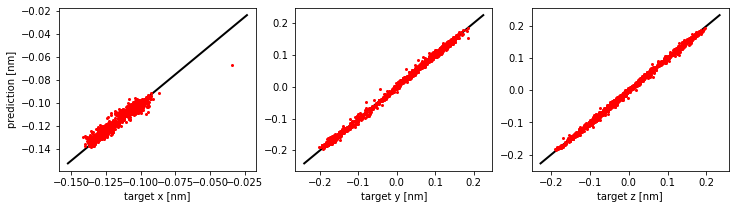

x: r2 0.9299478250534052 slope 0.9017469781263737 offset -0.010002740618150527
y: r2 0.9983268840166555 slope 1.0061720935417209 offset 0.0008258783902176867
z: r2 0.9969550170696113 slope 1.0044848917727778 offset 0.00033692226387609624
C


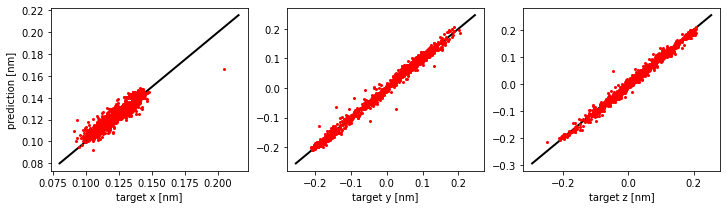

x: r2 0.8290321487713552 slope 0.8294146291265034 offset 0.021746382114886595
y: r2 0.9951297295035184 slope 1.01319558078282 offset 0.002450597311862465
z: r2 0.9870650836428472 slope 1.001585245131383 offset -0.0017673296310564204
O


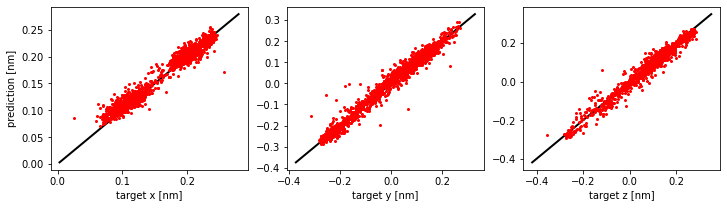

x: r2 0.9605426144676689 slope 0.9251626602058478 offset 0.016869100867722114
y: r2 0.9813830073053161 slope 1.0115496279548835 offset 0.0044834639022414274
z: r2 0.9669870601464664 slope 0.9877337010429458 offset -0.0024418578850204237


In [60]:
aa='MET'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")


0 0.0011294694692774324 0.00042506555675549953
1 0.0004026887138740572 0.000363202591525389
2 0.0003601187333411186 0.0003404271607875077
3 0.0003391526912369567 0.00033605259004073376
4 0.0003270119835134046 0.00033182939027448044
5 0.0003170460359036892 0.00031762606547406264
6 0.00030379184974036865 0.00029941716556182446
7 0.00029746528483973054 0.0003127607242442135
8 0.00029239041032269597 0.00032191702563708584
9 0.00028894995324901443 0.0002991114462952014


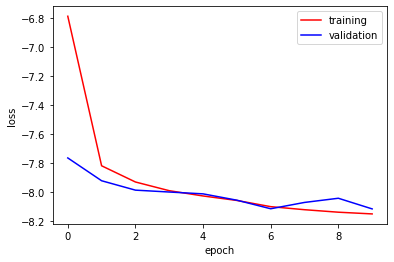

CA


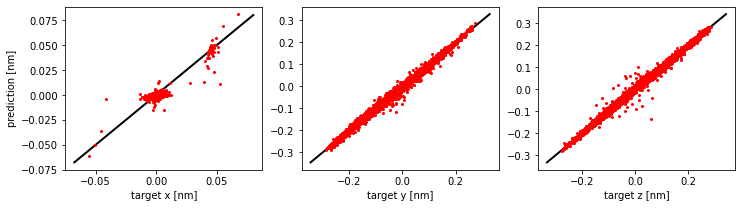

x: r2 0.7541406969144986 slope 0.7764411254091035 offset -0.00026085906285783136
y: r2 0.9971988794235005 slope 0.993830701216479 offset -0.0013691229909122693
z: r2 0.9967163884290725 slope 0.9972605023991685 offset 0.002424999338008063
N


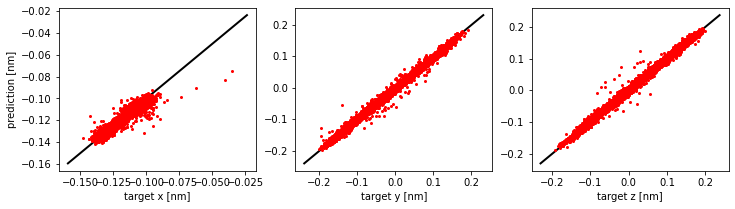

x: r2 0.9328520513590473 slope 0.9153853030073517 offset -0.010229175321928213
y: r2 0.9960097272268892 slope 0.9896297732380547 offset -0.0010810526606242765
z: r2 0.9950439810470969 slope 0.9937514717421949 offset 0.0030764695594001426
C


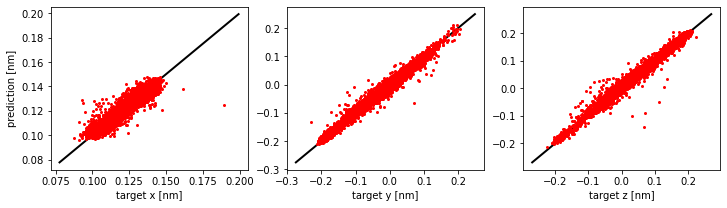

x: r2 0.9055458304728631 slope 0.9203533460055447 offset 0.010221273152618629
y: r2 0.9882393471158558 slope 0.9771953658618139 offset -0.0008288727421661563
z: r2 0.9860284469138951 slope 0.9867755754442039 offset 0.004415752109185246
O


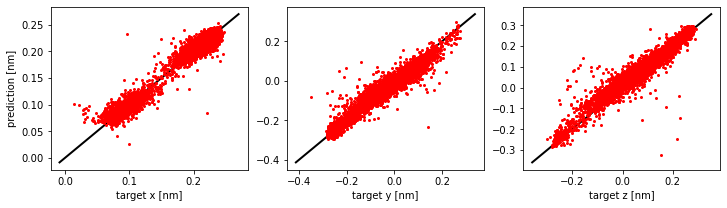

x: r2 0.9764514902346675 slope 0.9839057126343188 offset 0.003240605632764737
y: r2 0.9606578928626802 slope 0.9150658752347439 offset -0.009516882855591116
z: r2 0.9464127336391273 slope 0.9321344230664464 offset 0.017926909477769898


In [61]:
aa='GLY'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")


0 0.0013471944151784885 0.0004074132631619578
1 0.0003075725376909373 0.00026984063424671865
2 0.00025255506625398993 0.00025239867227208813
3 0.00023887666501457605 0.0002422020741007274
4 0.00023416869490492073 0.00023827804339660315
5 0.0002305099610980092 0.00023711812771132624
6 0.0002250132705684695 0.0002332123353664614
7 0.00022532423794142562 0.0002563223449887384
8 0.0002255816295721822 0.00023178859669097354
9 0.0002229577142067931 0.0002350155437305258


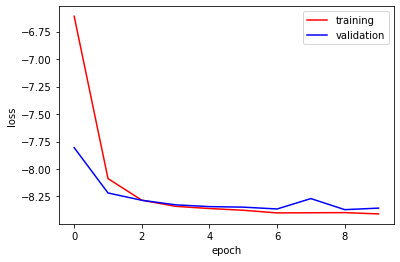

CA


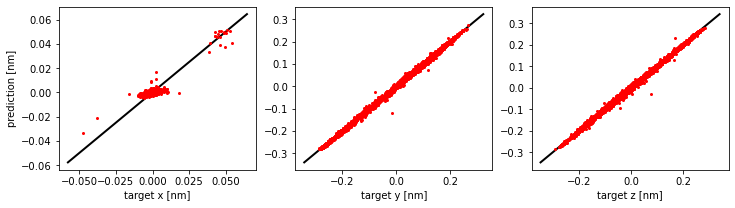

x: r2 0.7788976336678107 slope 0.7623514059206782 offset 3.141310165774772e-05
y: r2 0.9991478027680313 slope 1.0000588431831183 offset -9.840776143630464e-05
z: r2 0.9974479365052915 slope 0.9944555594841965 offset 8.725932503169526e-06
N


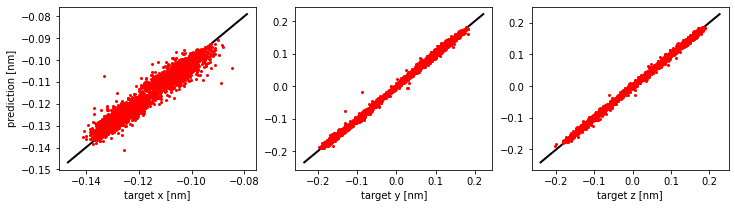

x: r2 0.9332564056736515 slope 0.9015293738010207 offset -0.010983047959518238
y: r2 0.9981804123405283 slope 1.0028475978345008 offset -8.697106638636681e-05
z: r2 0.9971261557756806 slope 0.9913201602468777 offset 0.0008150976909633411
C


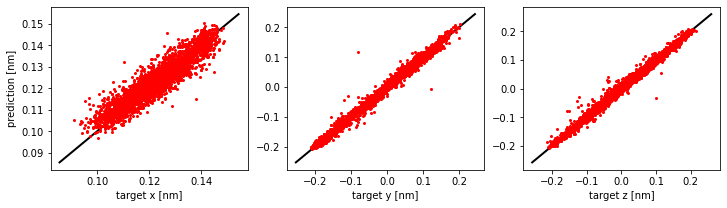

x: r2 0.8498050496186488 slope 0.8513875689642738 offset 0.01914037423934012
y: r2 0.9938881513191765 slope 1.0027698406601462 offset 0.0015469366037416665
z: r2 0.9873305032183802 slope 0.9887602635433279 offset 0.0025623761899619645
O


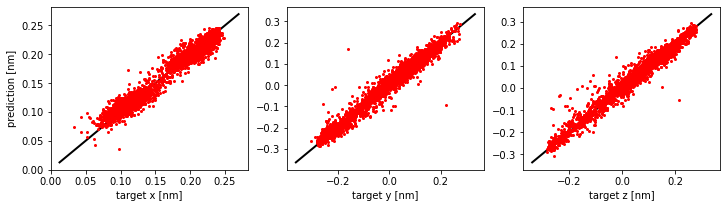

x: r2 0.9600853986456916 slope 0.9455113333618442 offset 0.009595348002822413
y: r2 0.9790793327541136 slope 0.9874592247437901 offset 0.0025259049435975497
z: r2 0.9667809831271382 slope 0.9659658427176294 offset 0.005156611918094481


In [62]:
aa='PHE'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")


0 0.001033970750817705 0.0003074571096815406
1 0.00025056711551176545 0.0002486598478169483
2 0.00022683660695886078 0.00023308076807635595
3 0.00021662490009633905 0.0002257583142824891
4 0.0002107341294860184 0.000262415359595865
5 0.0002110186096220075 0.00023129939617384294
6 0.00020648363114678827 0.00023845081525461604
7 0.00022510944140578985 0.00034706153962008897
8 0.00023229454223916906 0.0002288294563744827
9 0.00020325282853066355 0.0002213851031284196


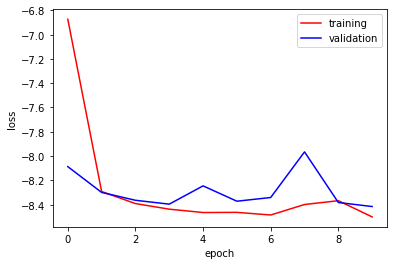

CA


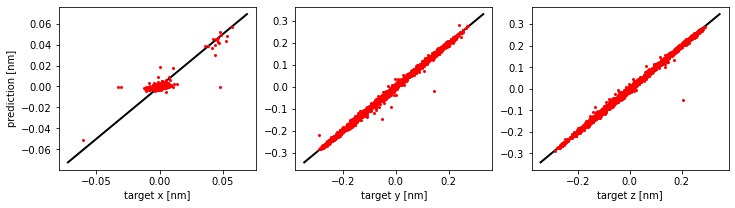

x: r2 0.6639044435229473 slope 0.6382563691611297 offset -3.945812932234755e-05
y: r2 0.9989617341312053 slope 1.0044872127743696 offset 0.0005932295269817506
z: r2 0.9974987434453075 slope 1.0001806479628348 offset -0.0001395664216196084
N


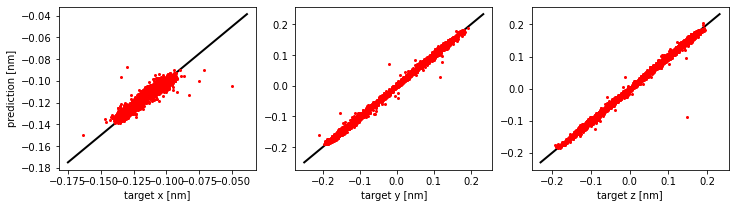

x: r2 0.9290525556698548 slope 0.9295801061776611 offset -0.0070602918425810846
y: r2 0.9982254596944394 slope 1.001163476679688 offset 8.02386698334212e-08
z: r2 0.9963526478219712 slope 1.0004336494903314 offset -0.00043803837063130166
C


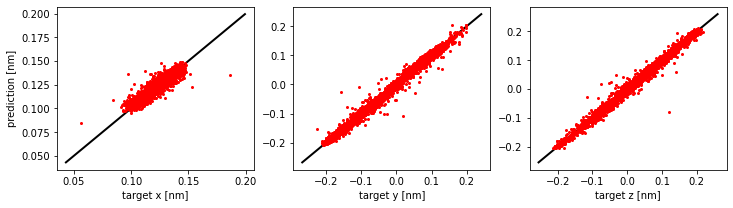

x: r2 0.8450337290596976 slope 0.8708165827767186 offset 0.01693853588725397
y: r2 0.9946572046376148 slope 1.0040821573985235 offset 0.0007259160465665354
z: r2 0.9898722241027859 slope 0.9989185103723975 offset -0.0003883120804132473
O


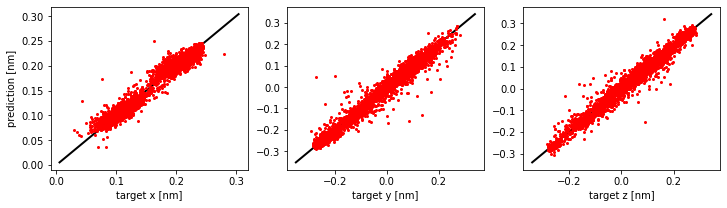

x: r2 0.9616111111457071 slope 0.9731839503969716 offset 0.006349333437110555
y: r2 0.9823701514131346 slope 0.985307032667576 offset -0.003393614449507046
z: r2 0.973440393603628 slope 0.9860085009005064 offset 0.0009184501897974984


In [63]:
aa='LYS'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")


0 0.0011741723066780907 0.000305849343578445
1 0.00027779338378399517 0.00023095989106876335
2 0.00023331322247544542 0.00022183532167941407
3 0.00022223039279476955 0.0002146365730704311
4 0.00021729350182562112 0.00021761487596501215
5 0.00021356129563616542 0.00022899526233987344
6 0.0002274068299298867 0.0002144402740980202
7 0.000209960198844783 0.0002179101421523787
8 0.00020813574463737986 0.0002120956952718461
9 0.00020462778831223169 0.00021445216999179805


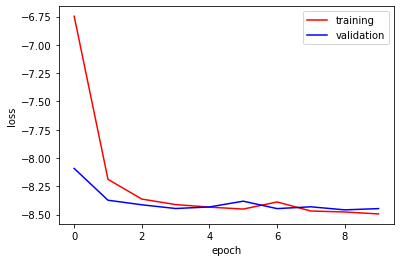

CA


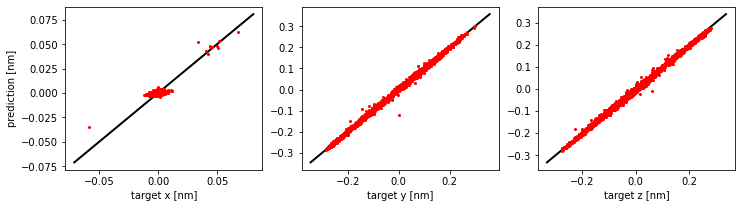

x: r2 0.6681181878448823 slope 0.6550269054649077 offset 1.9914624548648142e-05
y: r2 0.9991868596020569 slope 0.9997087347699931 offset 0.000735821701048453
z: r2 0.9978628927871626 slope 0.9910330038367248 offset -0.0016969650586499626
N


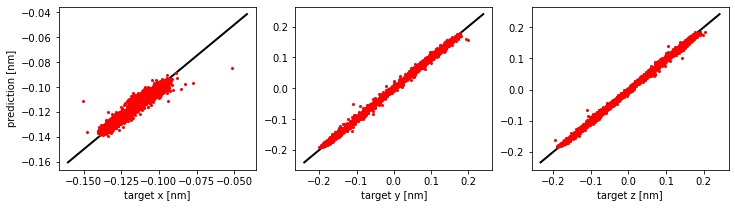

x: r2 0.9350284855624431 slope 0.937228899671266 offset -0.006629604320962934
y: r2 0.9983798418039792 slope 0.9979388649022634 offset 0.0011834771265848282
z: r2 0.9974728277591624 slope 0.9935209852721482 offset -0.0009502418444153095
C


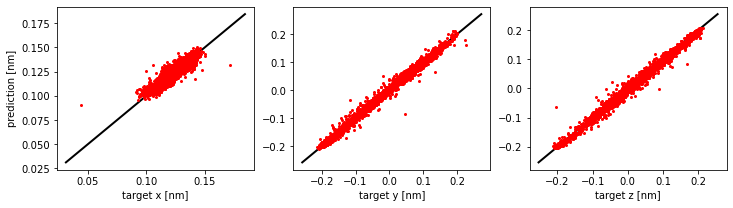

x: r2 0.8473911769677726 slope 0.8776130333685157 offset 0.015861166600174142
y: r2 0.9951686364823252 slope 1.0009298912509836 offset 0.0015462822885440597
z: r2 0.9891392767194811 slope 0.9877063390828446 offset -0.0018059589670346675
O


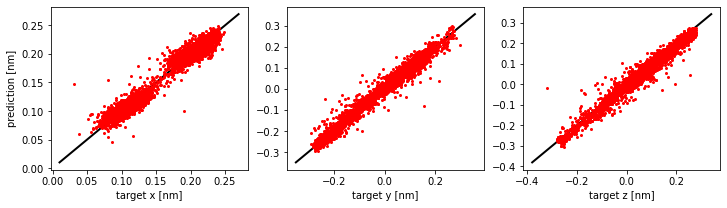

x: r2 0.9610651473642039 slope 0.9709949061640036 offset 0.005466455051805291
y: r2 0.9839518712995815 slope 0.992703409532745 offset 0.0009590430851307979
z: r2 0.9690827773663976 slope 0.982160251904894 offset -0.005432084364061979


In [64]:
aa='ARG'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")


0 0.0009940229398327776 0.00029794187180909423
1 0.00022370382761841432 0.00024109294769179227
2 0.0001981277264551156 0.0002293020293160147
3 0.00018872584106348868 0.00022276145582778283
4 0.000185462602853982 0.00022540124862116496
5 0.00018352766767040722 0.00021845300037044368
6 0.00018255237696899307 0.0002454870964320433
7 0.0001822165921718503 0.00022334472187313575
8 0.00017802885558921845 0.0002352290321549918
9 0.00017871450173616822 0.00021781795750137718


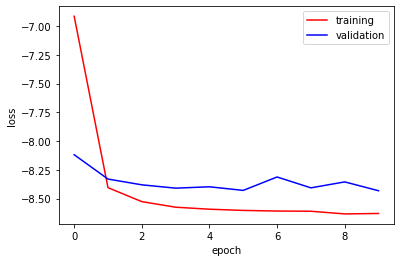

CA


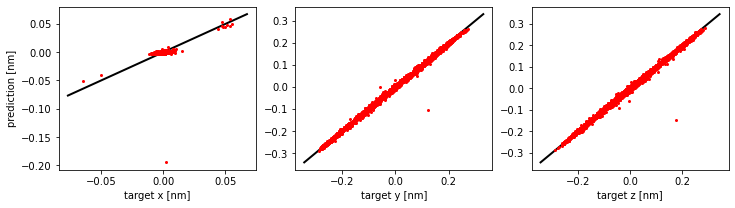

x: r2 0.298720960899413 slope 0.6456950445910559 offset -0.00016762764121875333
y: r2 0.9992754205656377 slope 0.9954326189090964 offset -0.0006473908138625167
z: r2 0.9964015471765504 slope 0.990401122351982 offset -0.0004153016042013284
N


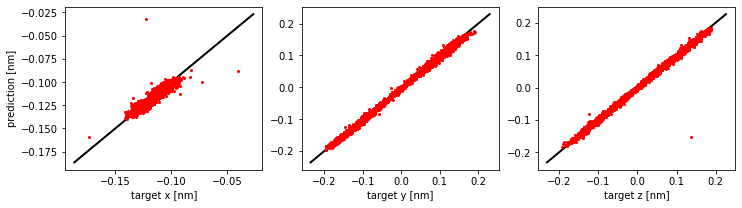

x: r2 0.9152717982968906 slope 0.9075681732621961 offset -0.011130800881538436
y: r2 0.9987334313198369 slope 0.992157574000814 offset -0.001931941470659948
z: r2 0.9953176068189112 slope 0.9868675058964461 offset -0.00014684412187522316
C


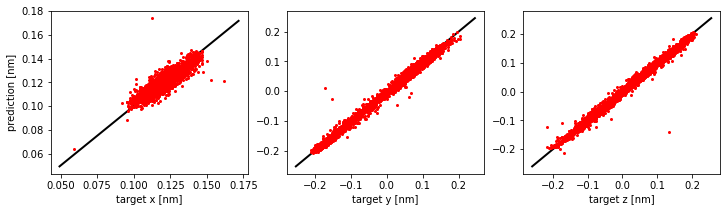

x: r2 0.7899839657354486 slope 0.8262306095367682 offset 0.020621240595877735
y: r2 0.9961944635462806 slope 0.984985830334187 offset -0.0032903996387796328
z: r2 0.9886929553953521 slope 0.9808592044085399 offset 0.0008211885195346866
O


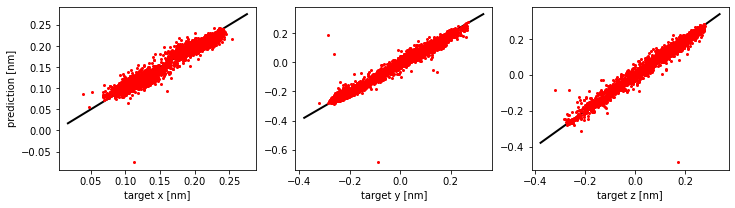

x: r2 0.9482896945445615 slope 0.9621101404918831 offset 0.004873964994559332
y: r2 0.9825605417965229 slope 0.9710354352707053 offset -0.007931269547043845
z: r2 0.9672096328765054 slope 0.9673974208680843 offset 0.0020439250726217023


In [65]:
aa='ILE'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")


0 0.0013045346642831795 0.00038209838195940094
1 0.00031555934991637195 0.0002918175675200465
2 0.0002657605450745118 0.0002712088596054569
3 0.00025216652264478743 0.00026177789374370734
4 0.00024843734541177953 0.0002641210114856785
5 0.0002378347161465098 0.0002600071606250082
6 0.00023475247852164447 0.00024932387967305095
7 0.0002292598006976265 0.0002470664669991392
8 0.00022466729923680022 0.0002445209362179627
9 0.0002206188451177818 0.0002408889546347264


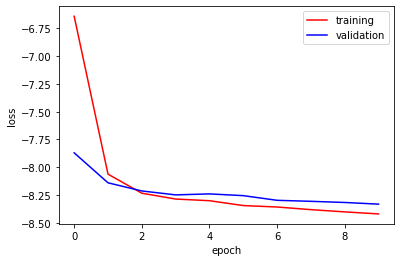

CA


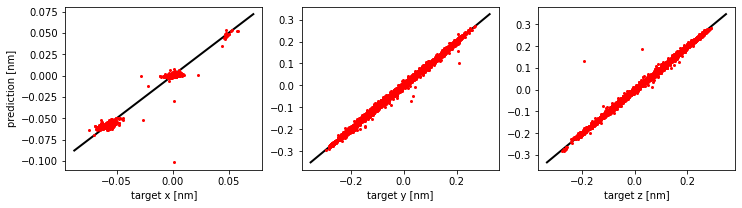

x: r2 0.9622472279946005 slope 0.9673400717206904 offset -0.0004354979932528996
y: r2 0.9977467188512334 slope 0.9957119733475218 offset 0.0006615532432726057
z: r2 0.9970937154609657 slope 0.993892424409586 offset -0.0005492013954218611
N


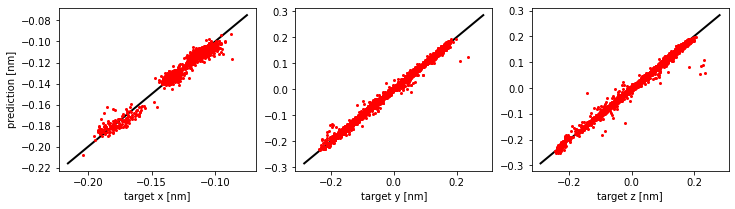

x: r2 0.9684068279547117 slope 0.9650198850300827 offset -0.00454386050493992
y: r2 0.9962164857451056 slope 0.9914618309929576 offset 0.000502056388759102
z: r2 0.9940503134463785 slope 0.9921238427980916 offset -0.001567150586294093
C


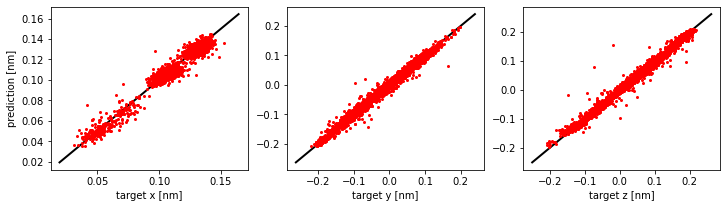

x: r2 0.955440281852971 slope 0.9568262621079829 offset 0.004328094855466785
y: r2 0.9903812928926674 slope 0.9928389759762091 offset 0.0015348397632261625
z: r2 0.9910437043352966 slope 0.9914049178220414 offset -0.00026043006856800444
O


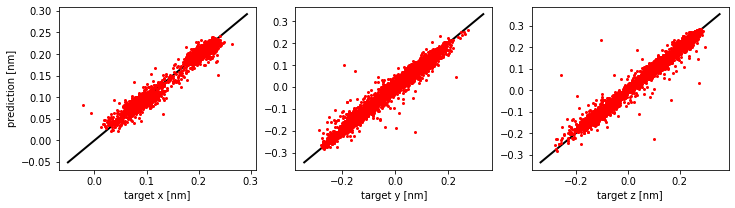

x: r2 0.9759990061546274 slope 0.9706958264175147 offset 0.0030883831260845596
y: r2 0.9680764722320254 slope 0.9657441517879687 offset 0.0027533607258175136
z: r2 0.979388255363188 slope 0.9795865401579975 offset 0.0017661563381454332


In [66]:
aa='PRO'

[tloader,vloader,txyzloader,vxyzloader]=\
    get_loaders('../generatingfeatures/longer_local_i_aa_capm2opmnpmcpm.dat',0.8,\
               batch_size=512,aa=aa,select="CANCO") 

m = Model1D3_ca_n_co()
m.apply(m.initialize_weights)
m.zero_grad()

m.load_state_dict(torch.load('PRO:ALA:VAL:LEU:ASP:SER:LYS:PHE_1d3_ca_n_co_predict.dict'),strict=False)

opt = torch.optim.Adam(m.parameters(),lr=0.0002, weight_decay=0.000001)

epochs=10
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,xscale=2.0)

plot_progress(epochs,tloss,vloss)

print('CA')
plot_validation(vxyzloader,m,0)
linear_regression(vxyzloader,m,0)

print('N')
plot_validation(vxyzloader,m,1)
linear_regression(vxyzloader,m,1)

print('C')
plot_validation(vxyzloader,m,2)
linear_regression(vxyzloader,m,2)

print('O')
plot_validation(vxyzloader,m,3)
linear_regression(vxyzloader,m,3)

torch.save(m.state_dict(),f"{aa}_1d3_ca_n_co_predict_aa.dict")
